# EDA

In [189]:
! pip install pandas

In [190]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
datasets_dir = '../app/data/'

### Load the Datasets

In [191]:
daily_trade_prices_df = pd.read_csv(datasets_dir + 'daily_trade_prices.csv')
dim_customer_df = pd.read_csv(datasets_dir + 'dim_customer.csv')
dim_date_df = pd.read_csv(datasets_dir + 'dim_date.csv')
dim_stock_df = pd.read_csv(datasets_dir + 'dim_stock.csv')
trades_df = pd.read_csv(datasets_dir + 'trades.csv')


In [192]:
def detect_missing_values(df):
    msno.matrix(df)
    return df.isnull().sum()

In [193]:
def detect_outliers_iqr(df, multiplier=1.5, threshold=0.1):
  numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
  interesting_cols = []
  for col in numerical_cols:
      q1 = df[col].quantile(0.25)
      q3 = df[col].quantile(0.75)
      iqr = q3 - q1
      lower_bound = q1 - multiplier * iqr
      upper_bound = q3 + multiplier * iqr
      outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
      print(f'Column: {col}, Outliers: {len(outliers)}')
      if len(outliers) >= threshold * len(df):
          interesting_cols.append(col)
  print(f'Columns with more than {threshold * 100}% outliers: {interesting_cols}')
  return interesting_cols

In [194]:
def detect_duplicate_rows(df):
    duplicate_rows = df[df.duplicated()]
    print(f'Number of duplicate rows: {len(duplicate_rows)}')

In [195]:
def plot_stock_prices(df):
    # Get all stock columns (exclude 'date' column)
    stock_columns = [col for col in df.columns if col != 'date']

    # Create a figure with subplots
    n_stocks = len(stock_columns)
    n_cols = 4  # Number of columns in subplot grid
    n_rows = (n_stocks + n_cols - 1) // n_cols  # Calculate required rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    # Fix: Handle the case when there's only one subplot (n_rows=1, n_cols=1)
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    # Convert date to datetime once for better performance
    dates = pd.to_datetime(df['date'])
    
    # Plot each stock
    for idx, stock in enumerate(stock_columns):
        ax = axes[idx]
        # Use simpler plotting without excessive styling
        ax.plot(dates, df[stock], linewidth=1)
        ax.set_title(f'{stock}', fontsize=10)
        ax.set_xlabel('Date', fontsize=8)
        ax.set_ylabel('Price ($)', fontsize=8)
        ax.grid(True, alpha=0.3)
        # Reduce number of x-axis ticks for performance
        ax.locator_params(axis='x', nbins=5)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    # Hide any unused subplots
    for idx in range(n_stocks, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Also create an overlay plot showing all stocks together
    plt.figure(figsize=(16, 8))
    for stock in stock_columns:
        plt.plot(dates, df[stock], label=stock, alpha=0.6, linewidth=1)

    plt.title('All Stock Prices Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

------
## daily trades prices


In [196]:
daily_trade_prices_df.head()

,date,STK001,STK002,STK003,STK004,STK005,STK006,STK007,STK008,STK009,...,STK011,STK012,STK013,STK014,STK015,STK016,STK017,STK018,STK019,STK020
0,2023-01-02,130.215257,143.732847,10.829021,41.721087,145.478750,136.613229,193.549026,154.597180,190.646814,...,66.629920,30.019335,158.546534,132.388352,19.155342,78.409589,191.791965,105.076218,92.218536,96.962925
1,2023-01-03,127.931982,141.811103,10.840378,42.372205,150.451171,131.081439,189.433498,156.245870,188.642260,...,67.403967,NaN,157.962636,132.316777,19.495879,81.278706,196.519348,105.143629,93.324523,NaN
2,2023-01-04,126.531338,139.814796,10.824561,43.273956,150.121855,132.287593,185.192571,153.568772,199.054913,...,65.541600,28.336211,157.022235,128.554686,19.489534,79.565899,195.192089,106.084249,93.996184,96.034921
3,2023-01-05,127.837687,140.885311,10.874388,43.307331,154.264000,127.534322,189.023341,155.642891,NaN,...,66.558603,27.706730,154.660460,120.788272,18.989024,83.375297,193.497711,104.311590,92.687024,96.281810
4,2023-01-06,127.140842,143.103993,11.212466,46.389494,151.434469,125.356736,185.290655,155.942939,203.068155,...,67.339732,27.283299,159.619771,112.131796,18.700643,80.443424,189.787155,109.664184,88.463448,97.103757


In [197]:
daily_trade_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    504 non-null    object 
 1   STK001  462 non-null    float64
 2   STK002  504 non-null    float64
 3   STK003  504 non-null    float64
 4   STK004  450 non-null    float64
 5   STK005  504 non-null    float64
 6   STK006  504 non-null    float64
 7   STK007  504 non-null    float64
 8   STK008  504 non-null    float64
 9   STK009  447 non-null    float64
 10  STK010  504 non-null    float64
 11  STK011  504 non-null    float64
 12  STK012  468 non-null    float64
 13  STK013  504 non-null    float64
 14  STK014  504 non-null    float64
 15  STK015  504 non-null    float64
 16  STK016  504 non-null    float64
 17  STK017  504 non-null    float64
 18  STK018  504 non-null    float64
 19  STK019  450 non-null    float64
 20  STK020  447 non-null    float64
dtypes: float64(20), object(1)
memory usage:

In [198]:
daily_trade_prices_df.describe()

,STK001,STK002,STK003,STK004,STK005,STK006,STK007,STK008,STK009,STK010,STK011,STK012,STK013,STK014,STK015,STK016,STK017,STK018,STK019,STK020
count,462.000000,504.000000,504.000000,450.000000,504.000000,504.000000,504.000000,504.000000,447.000000,504.000000,504.000000,468.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,450.000000,447.000000
mean,73.238205,244.100783,18.613699,70.079679,118.119651,90.840386,144.137838,134.917071,385.828732,208.935922,80.533798,14.127433,130.328012,97.772363,18.775502,99.237435,158.404600,153.353919,49.994600,62.168241
std,34.957716,77.687785,4.207475,21.406187,34.374868,35.769128,14.337600,12.476715,85.293754,72.537670,5.271877,5.865185,19.172942,21.760270,2.380748,27.402439,29.789473,36.598541,16.552201,13.191803
min,34.777126,131.049903,10.824561,38.601760,64.112615,36.700463,120.582293,102.141669,188.642260,117.981340,65.541600,6.159503,91.626473,53.573700,13.073433,54.387697,116.074993,88.461445,30.479787,44.149604
25%,51.129147,166.219395,15.734831,53.605636,91.199819,51.138410,134.202791,126.104209,321.386311,148.320335,77.024487,9.552314,117.124849,80.358870,16.952671,76.012725,135.951816,129.300194,36.520028,51.002395
50%,59.600556,231.118590,18.505297,66.639674,108.535825,95.320580,140.679659,134.706533,377.454388,180.379824,80.789065,12.273066,128.661199,99.010655,19.005233,95.264963,146.144767,148.254446,45.974139,58.308000
75%,82.434208,331.255990,20.815200,83.040661,142.595110,121.136085,150.682253,143.521293,447.269737,262.844855,84.053107,18.992370,148.752093,113.955124,20.761443,124.671982,180.134788,178.068028,56.151881,73.119995
max,185.760327,364.537923,32.471581,140.893661,219.282017,151.990790,193.549026,162.286078,643.439990,405.450480,94.372496,30.019335,169.446176,165.223676,23.405962,165.456114,234.074568,248.857830,98.248350,104.111733


# Missing Values detection

date       0
STK001    42
STK002     0
STK003     0
STK004    54
STK005     0
STK006     0
STK007     0
STK008     0
STK009    57
STK010     0
STK011     0
STK012    36
STK013     0
STK014     0
STK015     0
STK016     0
STK017     0
STK018     0
STK019    54
STK020    57
dtype: int64

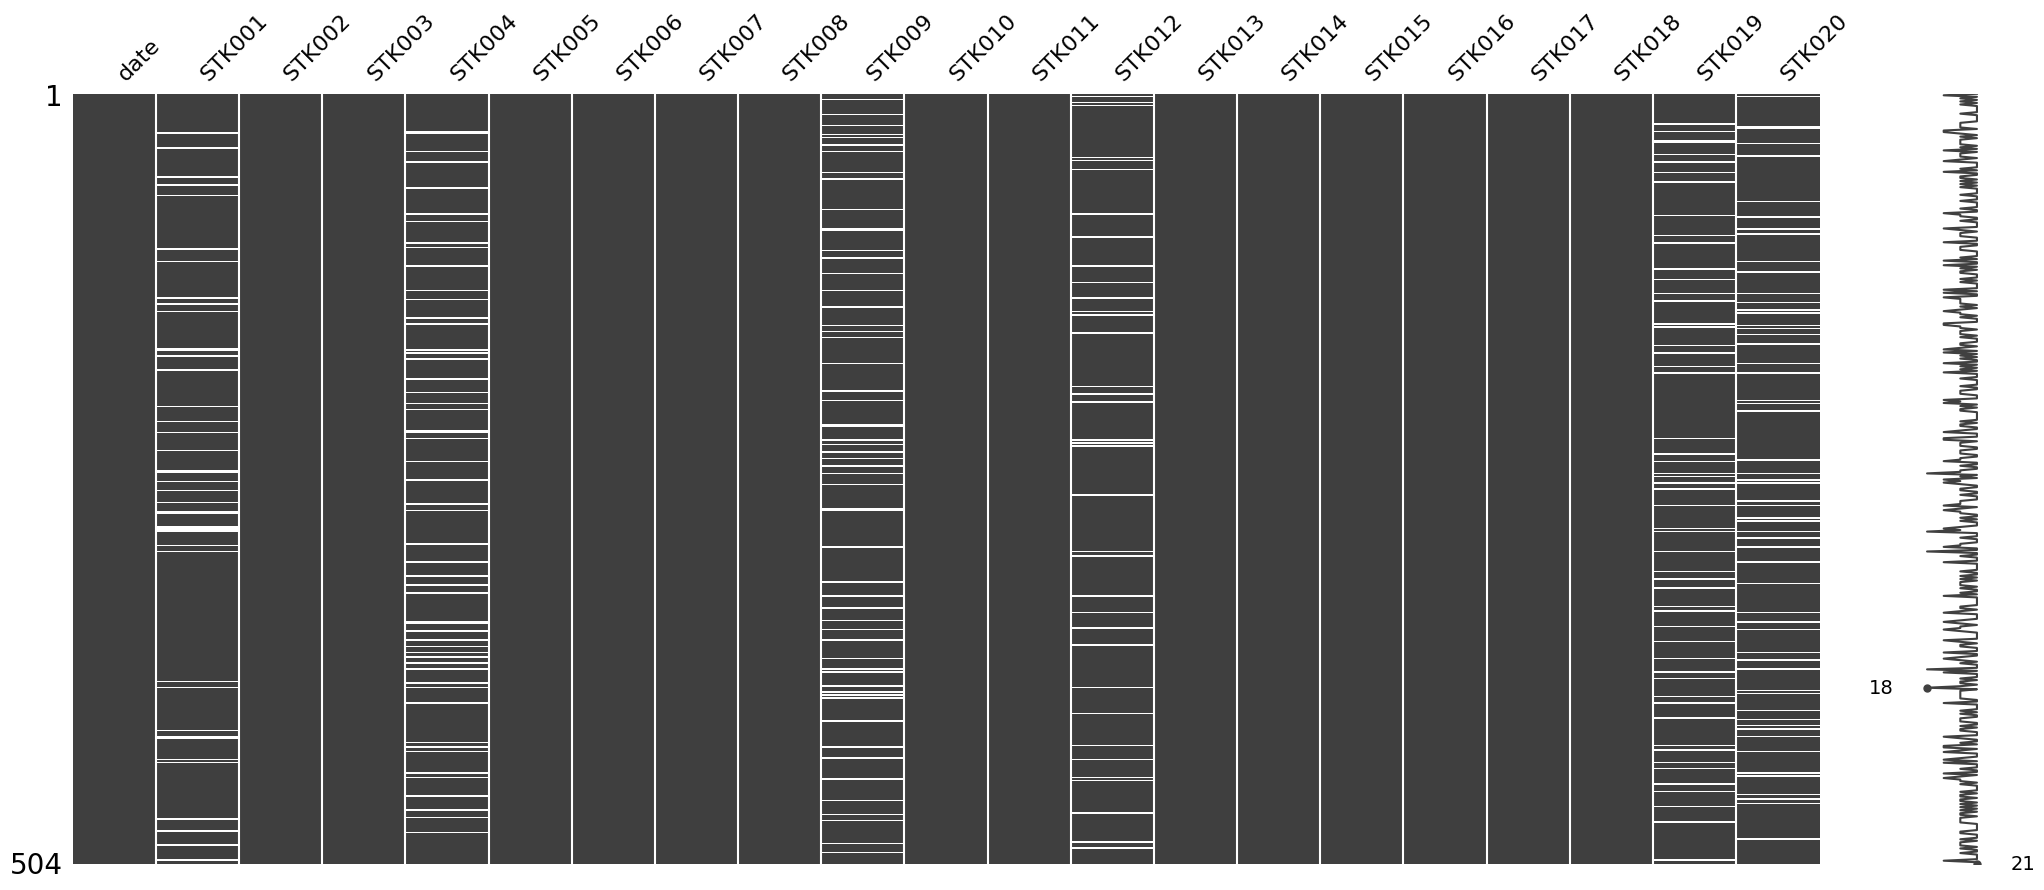

In [199]:
detect_missing_values(daily_trade_prices_df)

/tmp/ipykernel_30769/4135324209.py:32: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  ax.locator_params(axis='x', nbins=5)


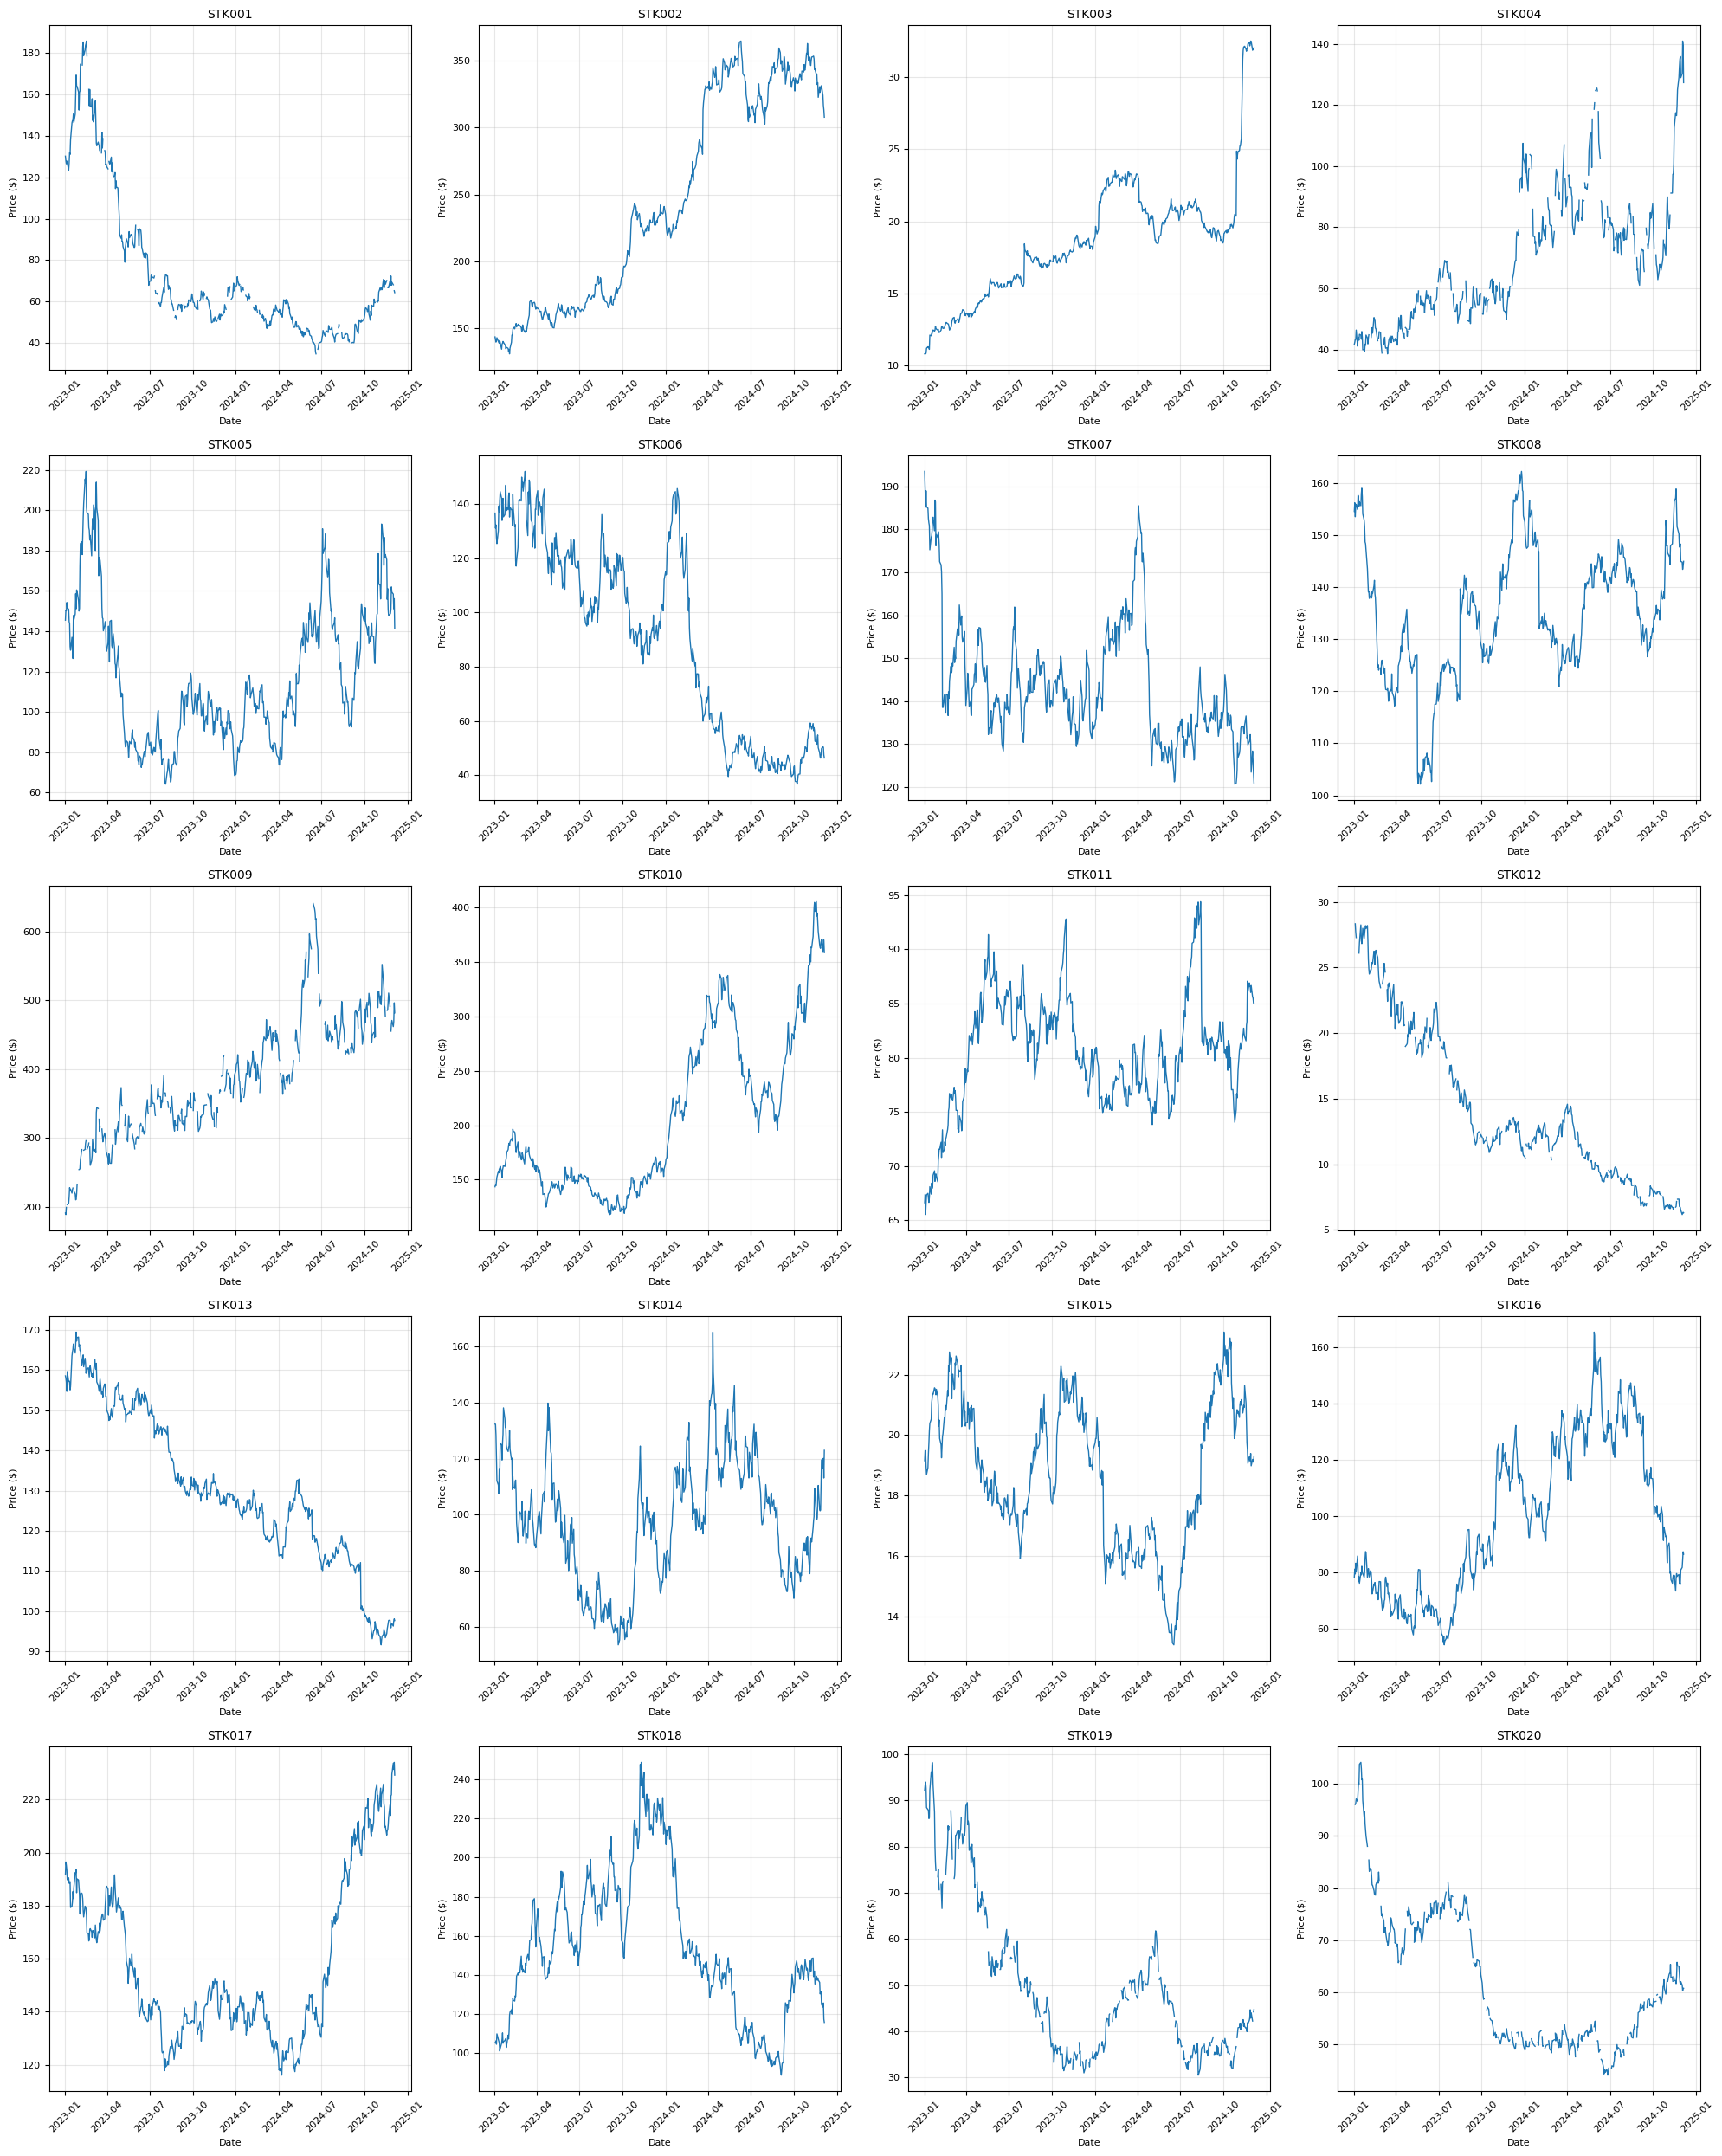

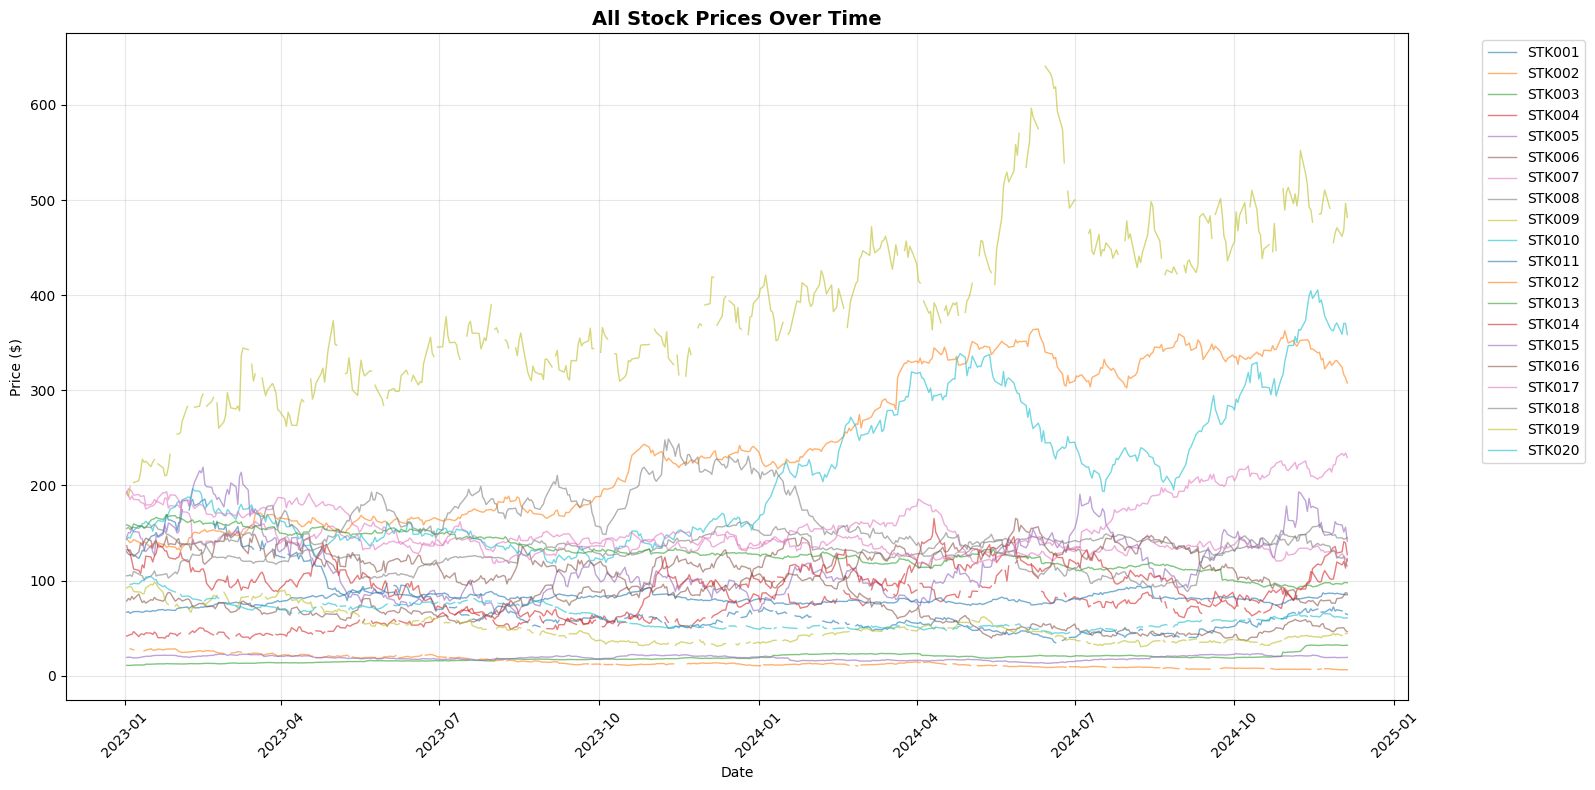

In [200]:
plot_stock_prices(daily_trade_prices_df)

# Duplicates and Inconsistencies Detection

In [201]:
# check for duplicate rows
detect_duplicate_rows(daily_trade_prices_df)

Number of duplicate rows: 0


In [202]:
# check for negative values in numerical columns
numerical_cols = daily_trade_prices_df.select_dtypes(include=[np.number]).columns.tolist()
for col in numerical_cols:
    negative_values = daily_trade_prices_df[daily_trade_prices_df[col] < 0]
    print(f'Column: {col}, Negative values: {len(negative_values)}')

Column: STK001, Negative values: 0
Column: STK002, Negative values: 0
Column: STK003, Negative values: 0
Column: STK004, Negative values: 0
Column: STK005, Negative values: 0
Column: STK006, Negative values: 0
Column: STK007, Negative values: 0
Column: STK008, Negative values: 0
Column: STK009, Negative values: 0
Column: STK010, Negative values: 0
Column: STK011, Negative values: 0
Column: STK012, Negative values: 0
Column: STK013, Negative values: 0
Column: STK014, Negative values: 0
Column: STK015, Negative values: 0
Column: STK016, Negative values: 0
Column: STK017, Negative values: 0
Column: STK018, Negative values: 0
Column: STK019, Negative values: 0
Column: STK020, Negative values: 0


# Outlier Detection

In [203]:
numerical_cols = daily_trade_prices_df.select_dtypes(include=[np.number]).columns.tolist()

## z-score method
- doesn't seem to be any significant outliers in the dataset, as the stock prices are not normally distributed as assumed by z-score method

In [204]:
# use z-score to identify outliers
# from scipy import stats
# z_scores = np.abs(stats.zscore(daily_trade_prices_df[numerical_cols]))
# print(z_scores)
# outlier_indices = np.where(z_scores > 3)
# outlier_rows = set(outlier_indices[0])
# print(f'Number of outlier rows identified by z-score method: {len(outlier_rows)}')

# # get the number of outliers per numerical column using z-score
# for i, col in enumerate(numerical_cols):
#     outlier_count = np.sum(z_scores[:, i] > 3)
#     print(f'Column: {col}, Outliers (z-score method): {outlier_count}')

# visualize outliers using z-score method
# for i, col in enumerate(numerical_cols):
#     plt.figure(figsize=(8, 4))
#     sns.scatterplot(x=daily_trade_prices_df.index, y=daily_trade_prices_df[col])
#     outlier_points = daily_trade_prices_df.index[z_scores[:, i] > 3]
#     plt.scatter(outlier_points, daily_trade_prices_df.loc[outlier_points, col], color='red', label='Outliers')
#     plt.title(f'Outliers in {col} using Z-score method')
#     plt.legend()
#     plt.show()
    

## Box-plot method

In [205]:
detect_outliers_iqr(daily_trade_prices_df)

Column: STK001, Outliers: 53
Column: STK002, Outliers: 0
Column: STK003, Outliers: 19
Column: STK004, Outliers: 9
Column: STK005, Outliers: 0
Column: STK006, Outliers: 0
Column: STK007, Outliers: 32
Column: STK008, Outliers: 0
Column: STK009, Outliers: 2
Column: STK010, Outliers: 0
Column: STK011, Outliers: 1
Column: STK012, Outliers: 0
Column: STK013, Outliers: 0
Column: STK014, Outliers: 1
Column: STK015, Outliers: 0
Column: STK016, Outliers: 0
Column: STK017, Outliers: 0
Column: STK018, Outliers: 0
Column: STK019, Outliers: 21
Column: STK020, Outliers: 0
Columns with more than 10.0% outliers: ['STK001']


['STK001']

In [206]:
# use box plots to visualize outliers
# for col in numerical_cols:
#     plt.figure(figsize=(8, 4))
#     sns.boxplot(x=daily_trade_prices_df[col])
#     plt.title(f'Box plot of {col}')
#     plt.show()
    

# Handling Missing Values

### Imputing the missing values using trades data

In [207]:
# Load trades data
trades_df_with_stk_freq = trades_df.copy()

# Convert timestamp to datetime for proper sorting
trades_df_with_stk_freq['timestamp'] = pd.to_datetime(trades_df_with_stk_freq['timestamp'])

# Sort by customer_id and timestamp
trades_df_with_stk_freq = trades_df_with_stk_freq.sort_values(['customer_id', 'timestamp']).reset_index(drop=True)

# Initialize stk_freq column with empty dictionaries
trades_df_with_stk_freq['stk_freq'] = [dict() for _ in range(len(trades_df_with_stk_freq))]

# Group by customer_id and compute cumulative stock frequencies
for customer_id, group in trades_df_with_stk_freq.groupby('customer_id'):
    # Get indices for this customer
    indices = group.index.tolist()
    
    # Initialize portfolio for this customer
    portfolio = {}
    
    # Loop through each transaction for this customer
    for idx in indices:
        stock_ticker = trades_df_with_stk_freq.loc[idx, 'stock_ticker']
        transaction_type = trades_df_with_stk_freq.loc[idx, 'transaction_type']
        quantity = trades_df_with_stk_freq.loc[idx, 'quantity']
        
        # Update portfolio based on transaction type
        if transaction_type == 'BUY':
            portfolio[stock_ticker] = portfolio.get(stock_ticker, 0) + quantity
        elif transaction_type == 'SELL':
            portfolio[stock_ticker] = portfolio.get(stock_ticker, 0) - quantity
            # Remove stock from portfolio if quantity becomes 0
            if portfolio[stock_ticker] <= 0:
                portfolio.pop(stock_ticker, None)
        
        # Store a copy of the current portfolio state
        trades_df_with_stk_freq.at[idx, 'stk_freq'] = portfolio.copy()

# Display first few rows to verify
print("Sample of trades_df with stk_freq column:")
print(trades_df_with_stk_freq.head(10))


Sample of trades_df with stk_freq column:
   transaction_id  timestamp  customer_id stock_ticker transaction_type  \
0            1636 2023-04-27            4       STK012              BUY   
1            2468 2023-06-28            4       STK018              BUY   
2            2621 2023-07-10            4       STK018             SELL   
3            3625 2023-09-19            4       STK018              BUY   
4            3858 2023-10-06            4       STK008              BUY   
5            5558 2024-01-24            4       STK012             SELL   
6            8660 2024-09-06            4       STK001              BUY   
7            9063 2024-10-02            4       STK018             SELL   
8            3647 2023-09-20           14       STK018              BUY   
9            3785 2023-10-02           15       STK009              BUY   

   quantity  average_trade_size  cumulative_portfolio_value  \
0       335              335.00                     6603.08   
1     

In [208]:
# Load daily trade prices
cleaned_daily_trade_prices_df = daily_trade_prices_df.copy()
cleaned_daily_trade_prices_df['date'] = pd.to_datetime(cleaned_daily_trade_prices_df['date'])

# Set date as index for easier lookup
cleaned_daily_trade_prices_df.set_index('date', inplace=True)

# Get stock ticker columns (all columns in daily_prices_df)
stock_columns = cleaned_daily_trade_prices_df.columns.tolist()


print("Starting price inference from portfolio values...")
print(f"Initial missing values: {cleaned_daily_trade_prices_df.isnull().sum().sum()}")

# Loop through each trade record
for idx, row in trades_df_with_stk_freq.iterrows():
    # Get the portfolio state and cumulative value
    portfolio = row['stk_freq']
    cumulative_value = row['cumulative_portfolio_value']
    trade_date = row['timestamp']
    customer_id = row['customer_id']
    
    # Skip if portfolio is empty
    if not portfolio:
        continue
    
    # Check if date exists in daily_prices_df
    if trade_date not in cleaned_daily_trade_prices_df.index:
        continue
    
    # Get prices for this date
    date_prices = cleaned_daily_trade_prices_df.loc[trade_date]
    
    # Count missing prices for stocks in portfolio
    missing_stocks = []
    known_stocks = []
    
    for stock in portfolio.keys():
        if pd.isna(date_prices[stock]):
            missing_stocks.append(stock)
        else:
            known_stocks.append(stock)
    
    # Only infer if exactly 1 stock price is missing
    if len(missing_stocks) == 1:
        missing_stock = missing_stocks[0]
        
        # Calculate the value of known stocks
        known_value = sum(date_prices[stock] * portfolio[stock] for stock in known_stocks)
        
        # Infer the missing stock price
        missing_quantity = portfolio[missing_stock]
        if missing_quantity > 0:
            inferred_price = (cumulative_value - known_value) / missing_quantity
            
            # Sanity check: price should be positive and reasonable
            if inferred_price > 0 and inferred_price < 10000:  # Basic bounds check
                # Store the inferred price directly in the daily_prices_df
                cleaned_daily_trade_prices_df.at[trade_date, missing_stock] = inferred_price

# Reset index to have date as a column again
cleaned_daily_trade_prices_df.reset_index(inplace=True)

print(f"\n{'='*60}")
print("Missing values after inference:")
missing_counts = cleaned_daily_trade_prices_df.isnull().sum()
print(missing_counts[missing_counts > 0])
print(f"\nTotal remaining missing values: {cleaned_daily_trade_prices_df.isnull().sum().sum()}")



Starting price inference from portfolio values...
Initial missing values: 300

Missing values after inference:
STK001    1
STK019    1
STK020    1
dtype: int64

Total remaining missing values: 3


date      0
STK001    1
STK002    0
STK003    0
STK004    0
STK005    0
STK006    0
STK007    0
STK008    0
STK009    0
STK010    0
STK011    0
STK012    0
STK013    0
STK014    0
STK015    0
STK016    0
STK017    0
STK018    0
STK019    1
STK020    1
dtype: int64

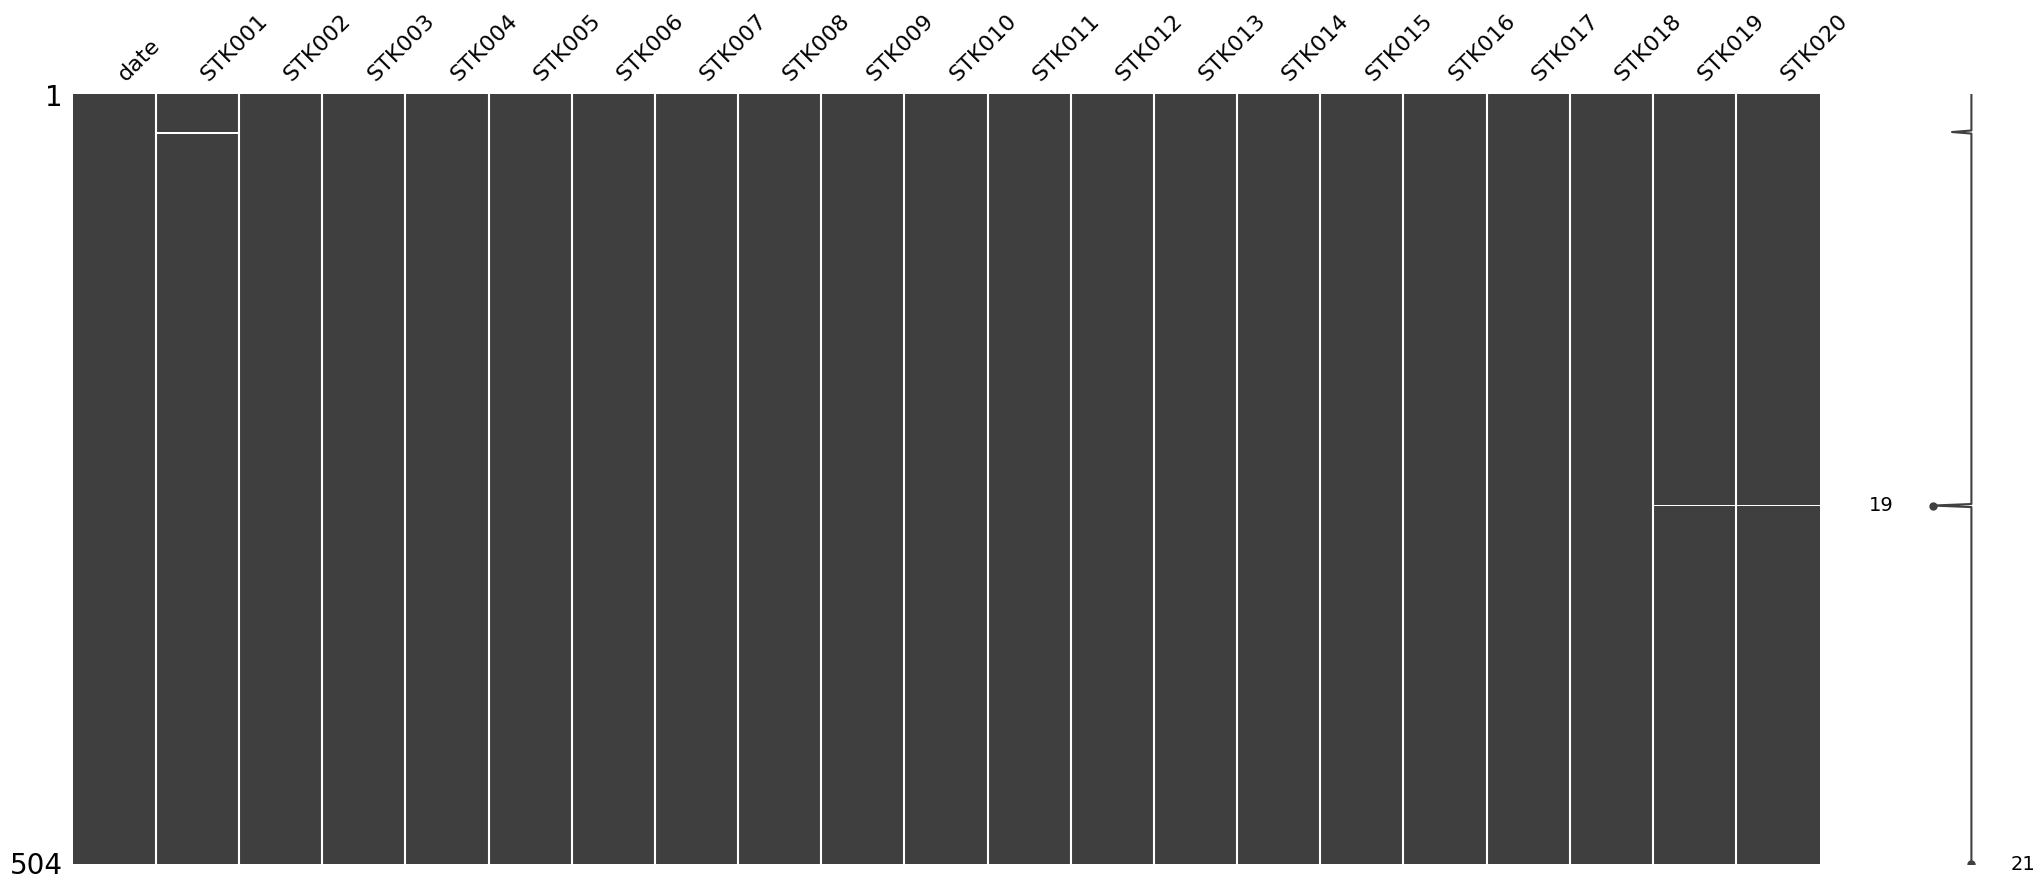

In [209]:
detect_missing_values(cleaned_daily_trade_prices_df)

/tmp/ipykernel_30769/447600024.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[stock_cols] = df_filled[stock_cols].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


date      0
STK001    0
STK002    0
STK003    0
STK004    0
STK005    0
STK006    0
STK007    0
STK008    0
STK009    0
STK010    0
STK011    0
STK012    0
STK013    0
STK014    0
STK015    0
STK016    0
STK017    0
STK018    0
STK019    0
STK020    0
dtype: int64

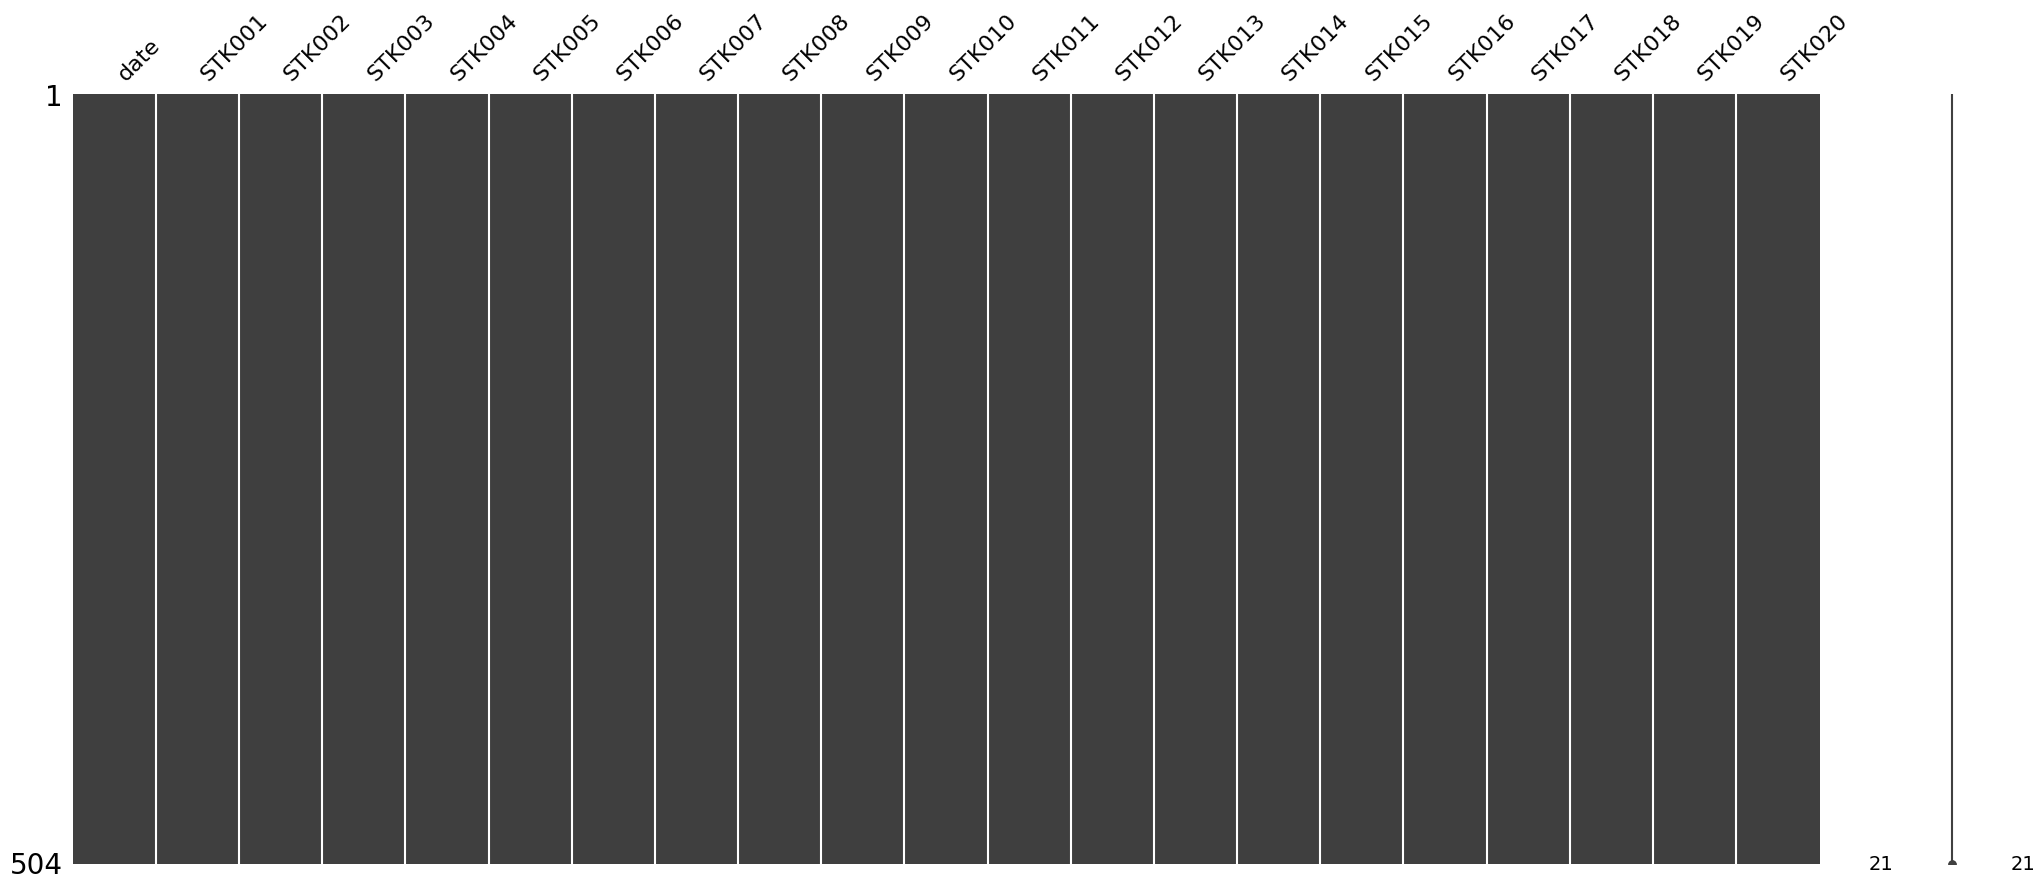

In [210]:
def handle_missing_values(df, method='ffill'):
    """
    Handle missing values in stock price data using forward/backward fill.
    
    Parameters:
    df (pd.DataFrame): DataFrame with date column and stock price columns
    method (str): 'ffill', 'bfill', or 'interpolate'
    
    Returns:
    pd.DataFrame: DataFrame with missing values filled
    """
    df_filled = df.copy()
    stock_cols = [col for col in df.columns if col != 'date']
    
    if method == 'ffill':
        df_filled[stock_cols] = df_filled[stock_cols].fillna(method='ffill').fillna(method='bfill')
    elif method == 'bfill':
        df_filled[stock_cols] = df_filled[stock_cols].fillna(method='bfill').fillna(method='ffill')
    elif method == 'interpolate':
        df_filled[stock_cols] = df_filled[stock_cols].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    
    return df_filled

cleaned_daily_trade_prices_df = handle_missing_values(cleaned_daily_trade_prices_df, method='interpolate')

detect_missing_values(cleaned_daily_trade_prices_df)

# Outlier handling
- need to be done before imputing missing values; as it will affect the imputation source of truth

In [211]:
def handle_outliers(df, method='cap', threshold=0.1, multiplier=1.5):
    df_clean = df.copy()
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    
    print(f"\n{'='*60}")
    print(f"Outlier Handling Report (Threshold: {threshold*100}%)")
    print(f"{'='*60}\n")
    
    for col in numerical_cols:
        # Calculate IQR bounds
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - multiplier * iqr
        upper_bound = q3 + multiplier * iqr
        
        # Detect outliers
        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_count = outlier_mask.sum()
        outlier_proportion = outlier_count / len(df)
        
        # Only handle if outliers exceed threshold
        if outlier_proportion >= threshold:
            print(f"✓ {col}: {outlier_count} outliers ({outlier_proportion*100:.2f}%) - HANDLING")
            if method == 'cap':
                # Cap at IQR bounds (matches detection method)
                df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
            elif method == 'interpolate':
                # Replace outliers with NaN and interpolate
                df_clean.loc[outlier_mask, col] = np.nan
                df_clean[col] = df_clean[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
            elif method == 'log':
                # Log transform the values (only positive values allowed)
                # Add 1 if necessary to avoid log(0)
                min_val = df_clean[col].min()
                offset = 1 - min_val if min_val <= 0 else 0
                df_clean[col] = np.log(df_clean[col] + offset)
            elif method == 'zscore':
                # Standardize the column using z-score normalization
                print(f"Standardizing {col} using z-score normalization")
                mean = df_clean[col].mean()
                std = df_clean[col].std()
                print(f"Mean: {mean}, Std: {std}")
                df_clean[col] = (df_clean[col] - mean) / std
        else:
            print(f"  {col}: {outlier_count} outliers ({outlier_proportion*100:.2f}%) - SKIPPED")
    
    print(f"\n{'='*60}\n")
    return df_clean

# example usage
cleaned_daily_trade_prices_df = handle_outliers(cleaned_daily_trade_prices_df, method='log', threshold=0.1)


Outlier Handling Report (Threshold: 10.0%)

✓ STK001: 78 outliers (15.48%) - HANDLING
  STK002: 0 outliers (0.00%) - SKIPPED
  STK003: 19 outliers (3.77%) - SKIPPED
  STK004: 8 outliers (1.59%) - SKIPPED
  STK005: 0 outliers (0.00%) - SKIPPED
  STK006: 0 outliers (0.00%) - SKIPPED
  STK007: 32 outliers (6.35%) - SKIPPED
  STK008: 0 outliers (0.00%) - SKIPPED
  STK009: 4 outliers (0.79%) - SKIPPED
  STK010: 0 outliers (0.00%) - SKIPPED
  STK011: 1 outliers (0.20%) - SKIPPED
  STK012: 0 outliers (0.00%) - SKIPPED
  STK013: 0 outliers (0.00%) - SKIPPED
  STK014: 1 outliers (0.20%) - SKIPPED
  STK015: 0 outliers (0.00%) - SKIPPED
  STK016: 0 outliers (0.00%) - SKIPPED
  STK017: 0 outliers (0.00%) - SKIPPED
  STK018: 0 outliers (0.00%) - SKIPPED
  STK019: 22 outliers (4.37%) - SKIPPED
  STK020: 0 outliers (0.00%) - SKIPPED




In [212]:
detect_outliers_iqr(cleaned_daily_trade_prices_df)

Column: STK001, Outliers: 38
Column: STK002, Outliers: 0
Column: STK003, Outliers: 19
Column: STK004, Outliers: 8
Column: STK005, Outliers: 0
Column: STK006, Outliers: 0
Column: STK007, Outliers: 32
Column: STK008, Outliers: 0
Column: STK009, Outliers: 4
Column: STK010, Outliers: 0
Column: STK011, Outliers: 1
Column: STK012, Outliers: 0
Column: STK013, Outliers: 0
Column: STK014, Outliers: 1
Column: STK015, Outliers: 0
Column: STK016, Outliers: 0
Column: STK017, Outliers: 0
Column: STK018, Outliers: 0
Column: STK019, Outliers: 22
Column: STK020, Outliers: 0
Columns with more than 10.0% outliers: []


[]

/tmp/ipykernel_30769/4135324209.py:32: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  ax.locator_params(axis='x', nbins=5)


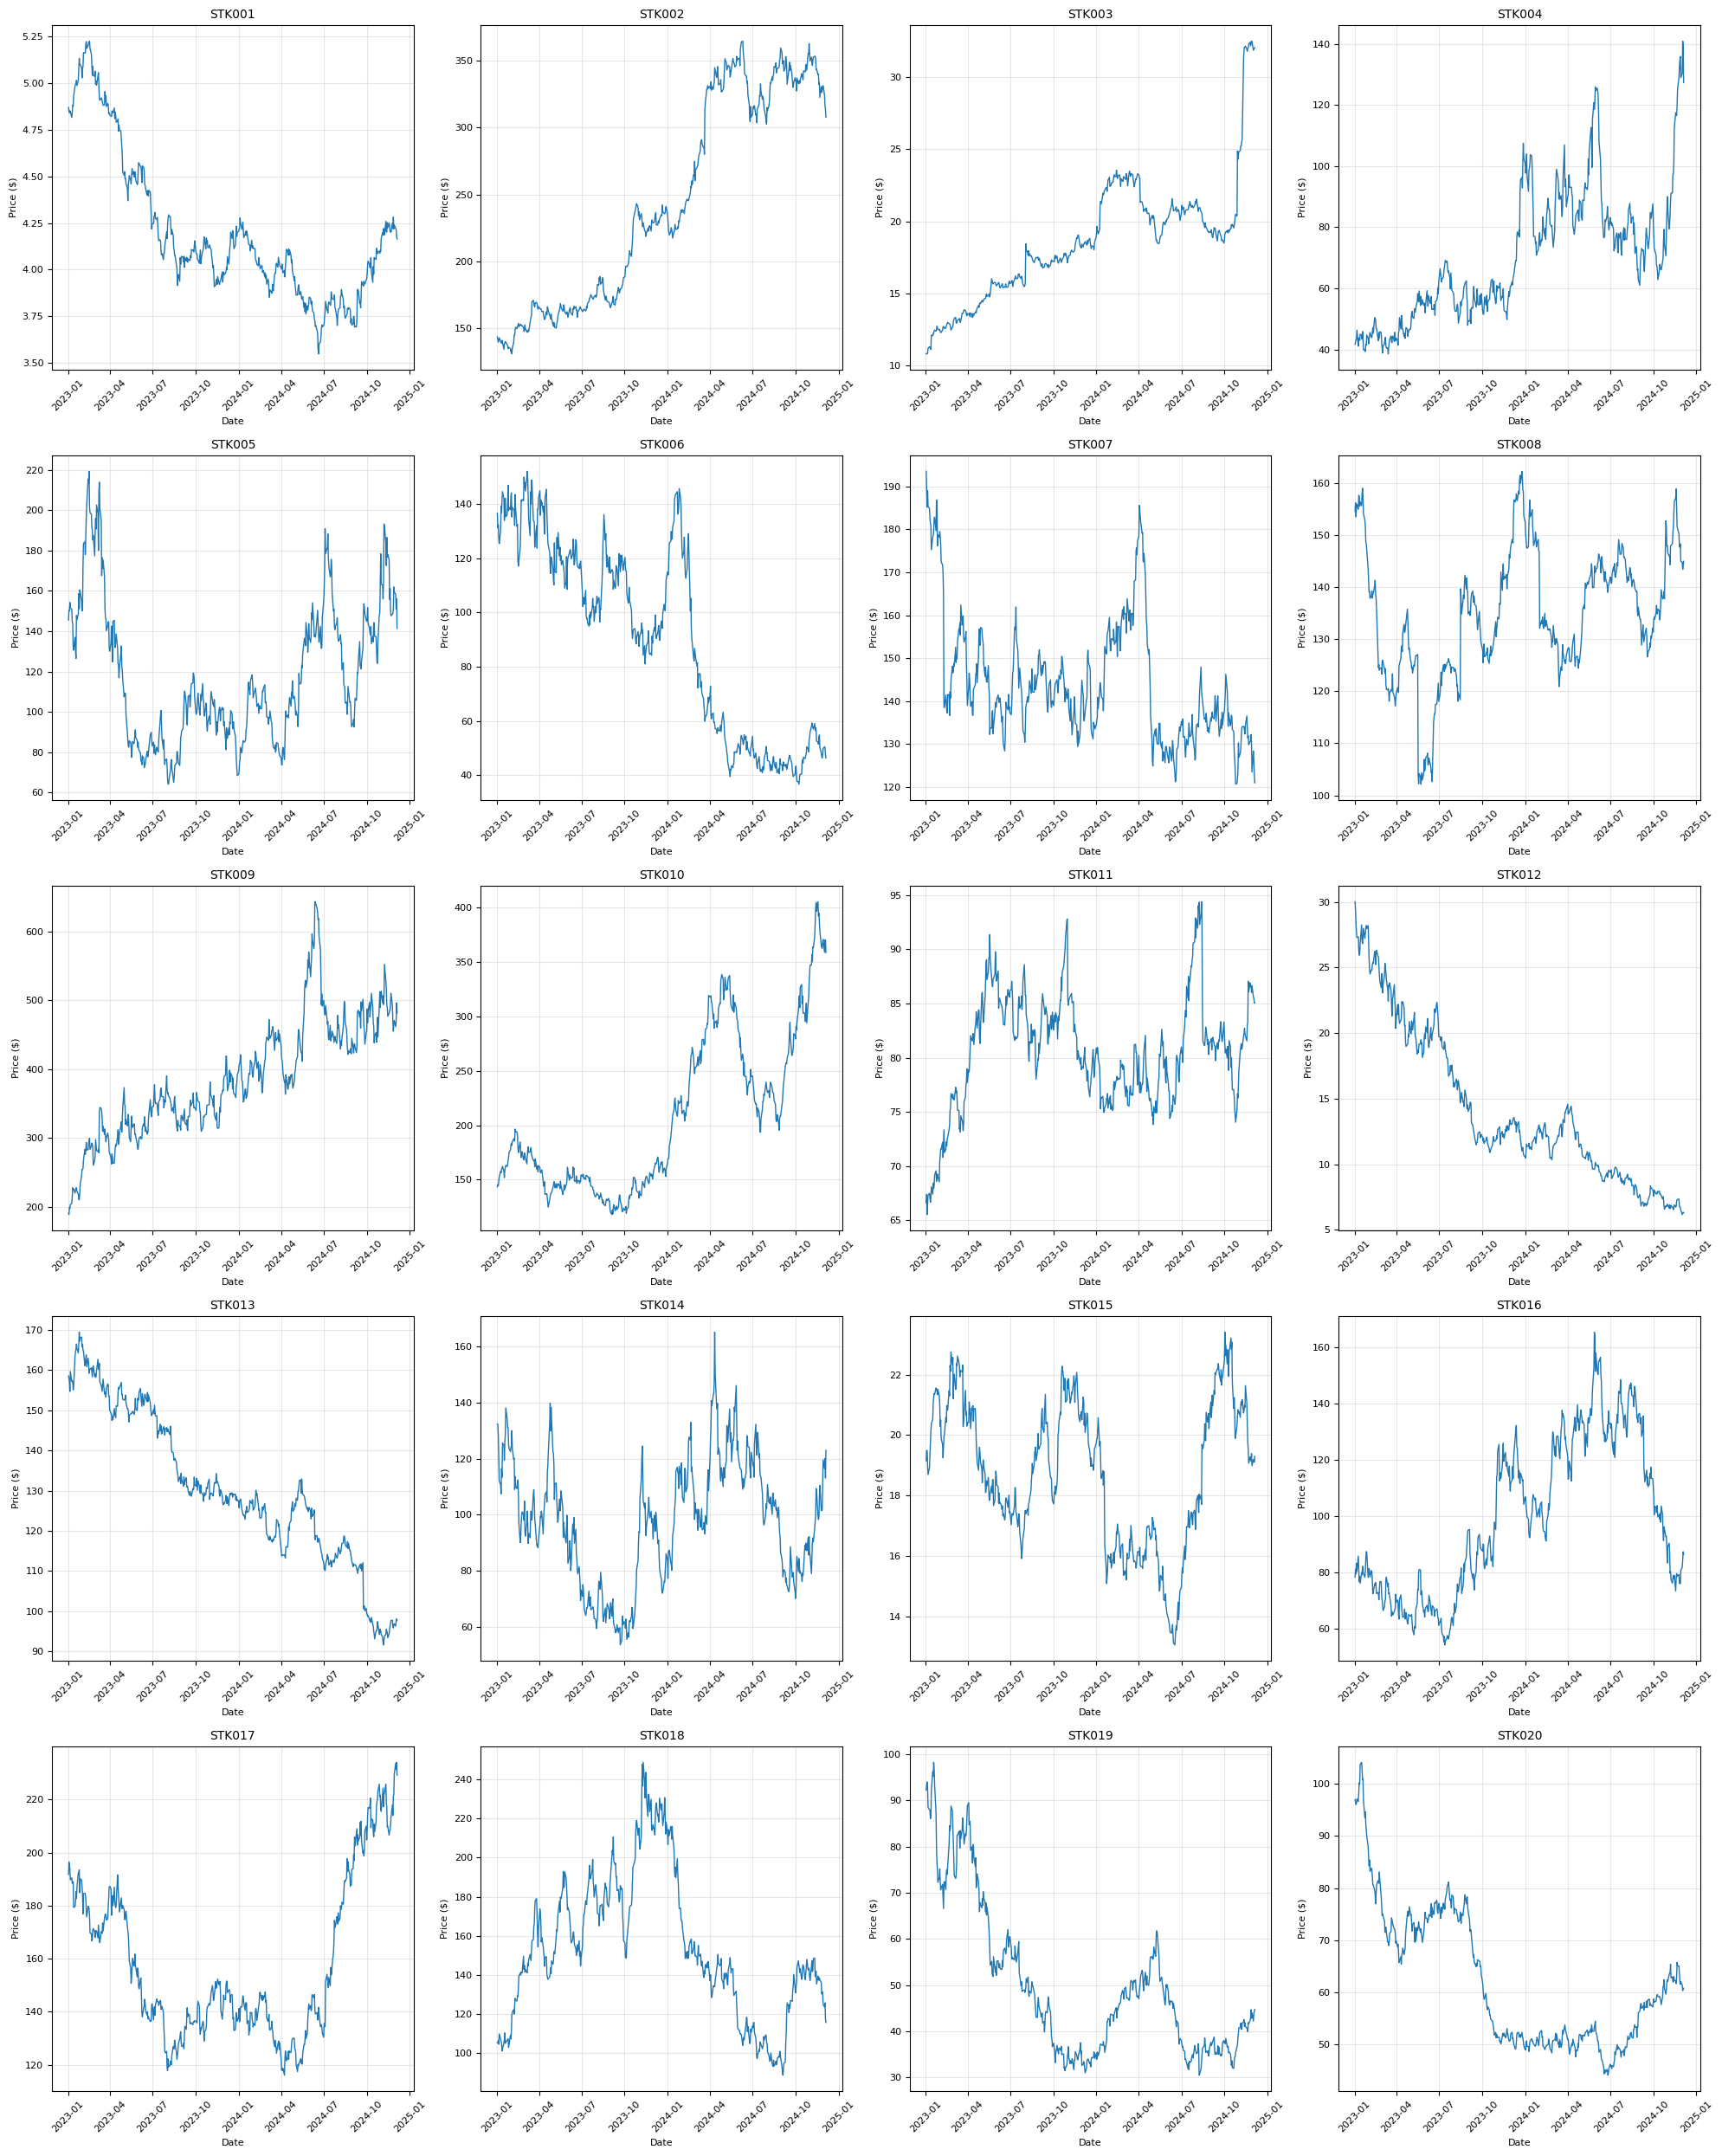

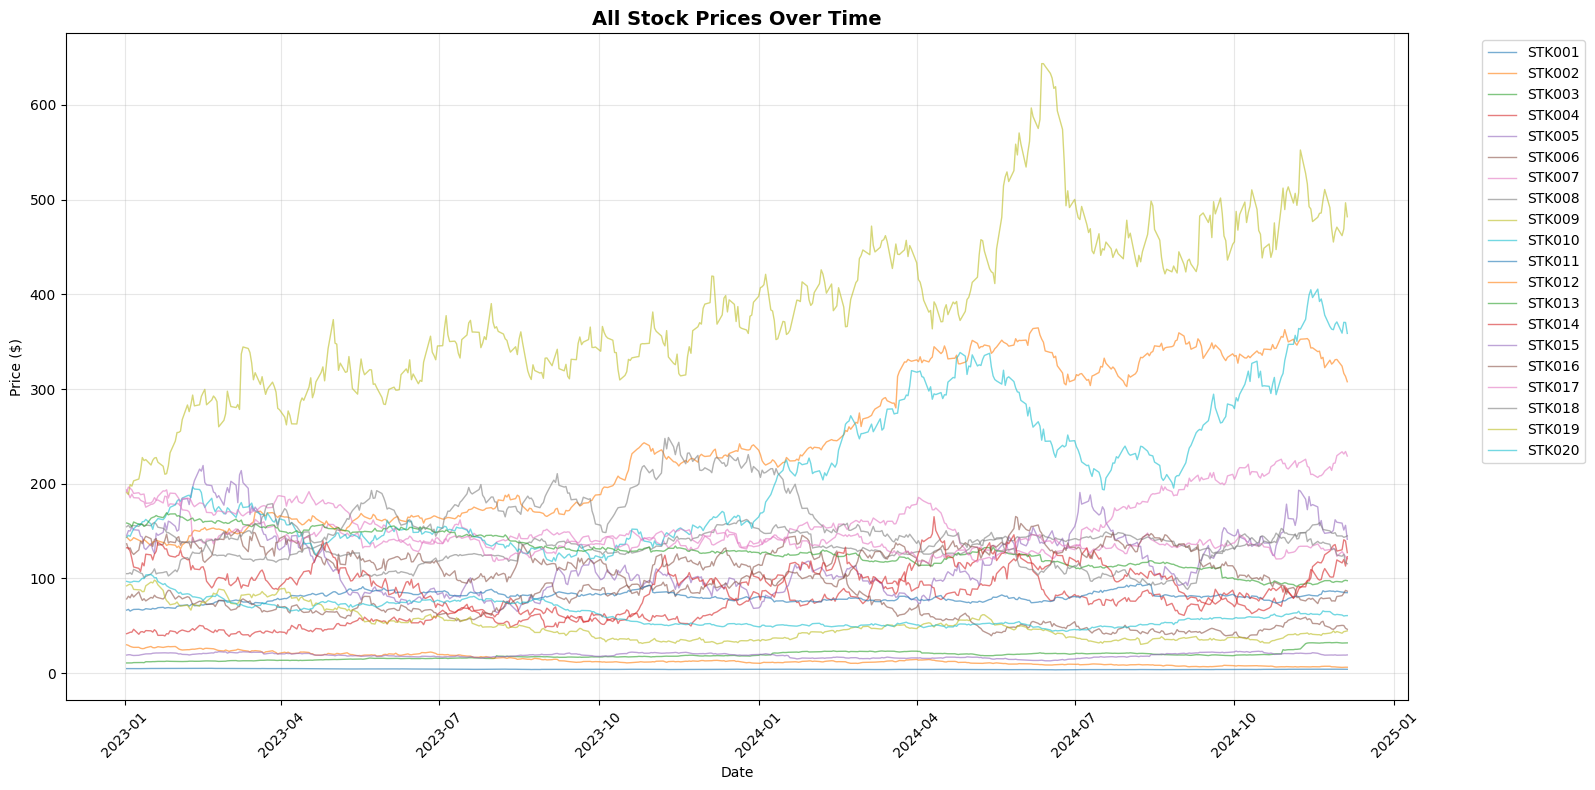

In [213]:
plot_stock_prices(cleaned_daily_trade_prices_df)

-----------
## trades

In [214]:
trades_df.head()

,transaction_id,timestamp,customer_id,stock_ticker,transaction_type,quantity,average_trade_size,cumulative_portfolio_value
0,1,2023-01-02,4747,STK002,BUY,15,15.00,2155.99
1,2,2023-01-02,4747,STK004,BUY,68,41.50,4993.03
2,3,2023-01-02,227,STK006,BUY,49,49.00,6694.05
3,4,2023-01-02,4747,STK006,BUY,503,195.33,73709.48
4,5,2023-01-02,3938,STK006,BUY,203,203.00,27732.49


In [215]:
trades_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   transaction_id              10000 non-null  int64  
 1   timestamp                   10000 non-null  object 
 2   customer_id                 10000 non-null  int64  
 3   stock_ticker                10000 non-null  object 
 4   transaction_type            10000 non-null  object 
 5   quantity                    10000 non-null  int64  
 6   average_trade_size          10000 non-null  float64
 7   cumulative_portfolio_value  10000 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 625.1+ KB


In [216]:
trades_df.describe()

,transaction_id,customer_id,quantity,average_trade_size,cumulative_portfolio_value
count,10000.00000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,5000.50000,3076.642900,210.599900,214.254502,1.740485e+06
std,2886.89568,1681.888717,287.791831,154.797352,2.369622e+06
min,1.00000,4.000000,1.000000,8.000000,0.000000e+00
25%,2500.75000,1513.000000,61.000000,176.270000,9.112538e+04
50%,5000.50000,3588.000000,123.000000,201.730000,7.727134e+05
75%,7500.25000,4747.000000,249.000000,212.632500,2.191020e+06
max,10000.00000,4998.000000,5000.000000,3401.000000,9.914939e+06


# Duplicates and Inconsistency Detection

In [217]:
trades_df['stock_ticker'].value_counts().sort_index()

stock_ticker
STK001      61
STK002      96
STK003     151
STK004      43
STK005     106
STK006    2257
STK007     232
STK008     387
STK009    1070
STK010     437
STK011     231
STK012    1656
STK013    1132
STK014      34
STK015      53
STK016      55
STK017     251
STK018    1173
STK019     261
STK020     314
Name: count, dtype: int64

In [218]:
trades_df['transaction_type'].value_counts().sort_index()

transaction_type
BUY     6739
SELL    3261
Name: count, dtype: int64

In [31]:
# check for negative values in 'quantity' column
negative_quantity = trades_df[trades_df['quantity'] < 0]
print(f'Negative values in quantity column: {len(negative_quantity)}')

Negative values in quantity column: 0


In [32]:
# check timestamp format in 'timestamp' column
trades_df['timestamp'] = pd.to_datetime(trades_df['timestamp'], errors='coerce')
invalid_dates = trades_df[trades_df['timestamp'].isnull()]
print(f'Invalid dates in timestamp column: {len(invalid_dates)}')

Invalid dates in timestamp column: 0


In [33]:
detect_duplicate_rows(trades_df)

Number of duplicate rows: 0


# Missing Values Detection

transaction_id                0
timestamp                     0
customer_id                   0
stock_ticker                  0
transaction_type              0
quantity                      0
average_trade_size            0
cumulative_portfolio_value    0
dtype: int64

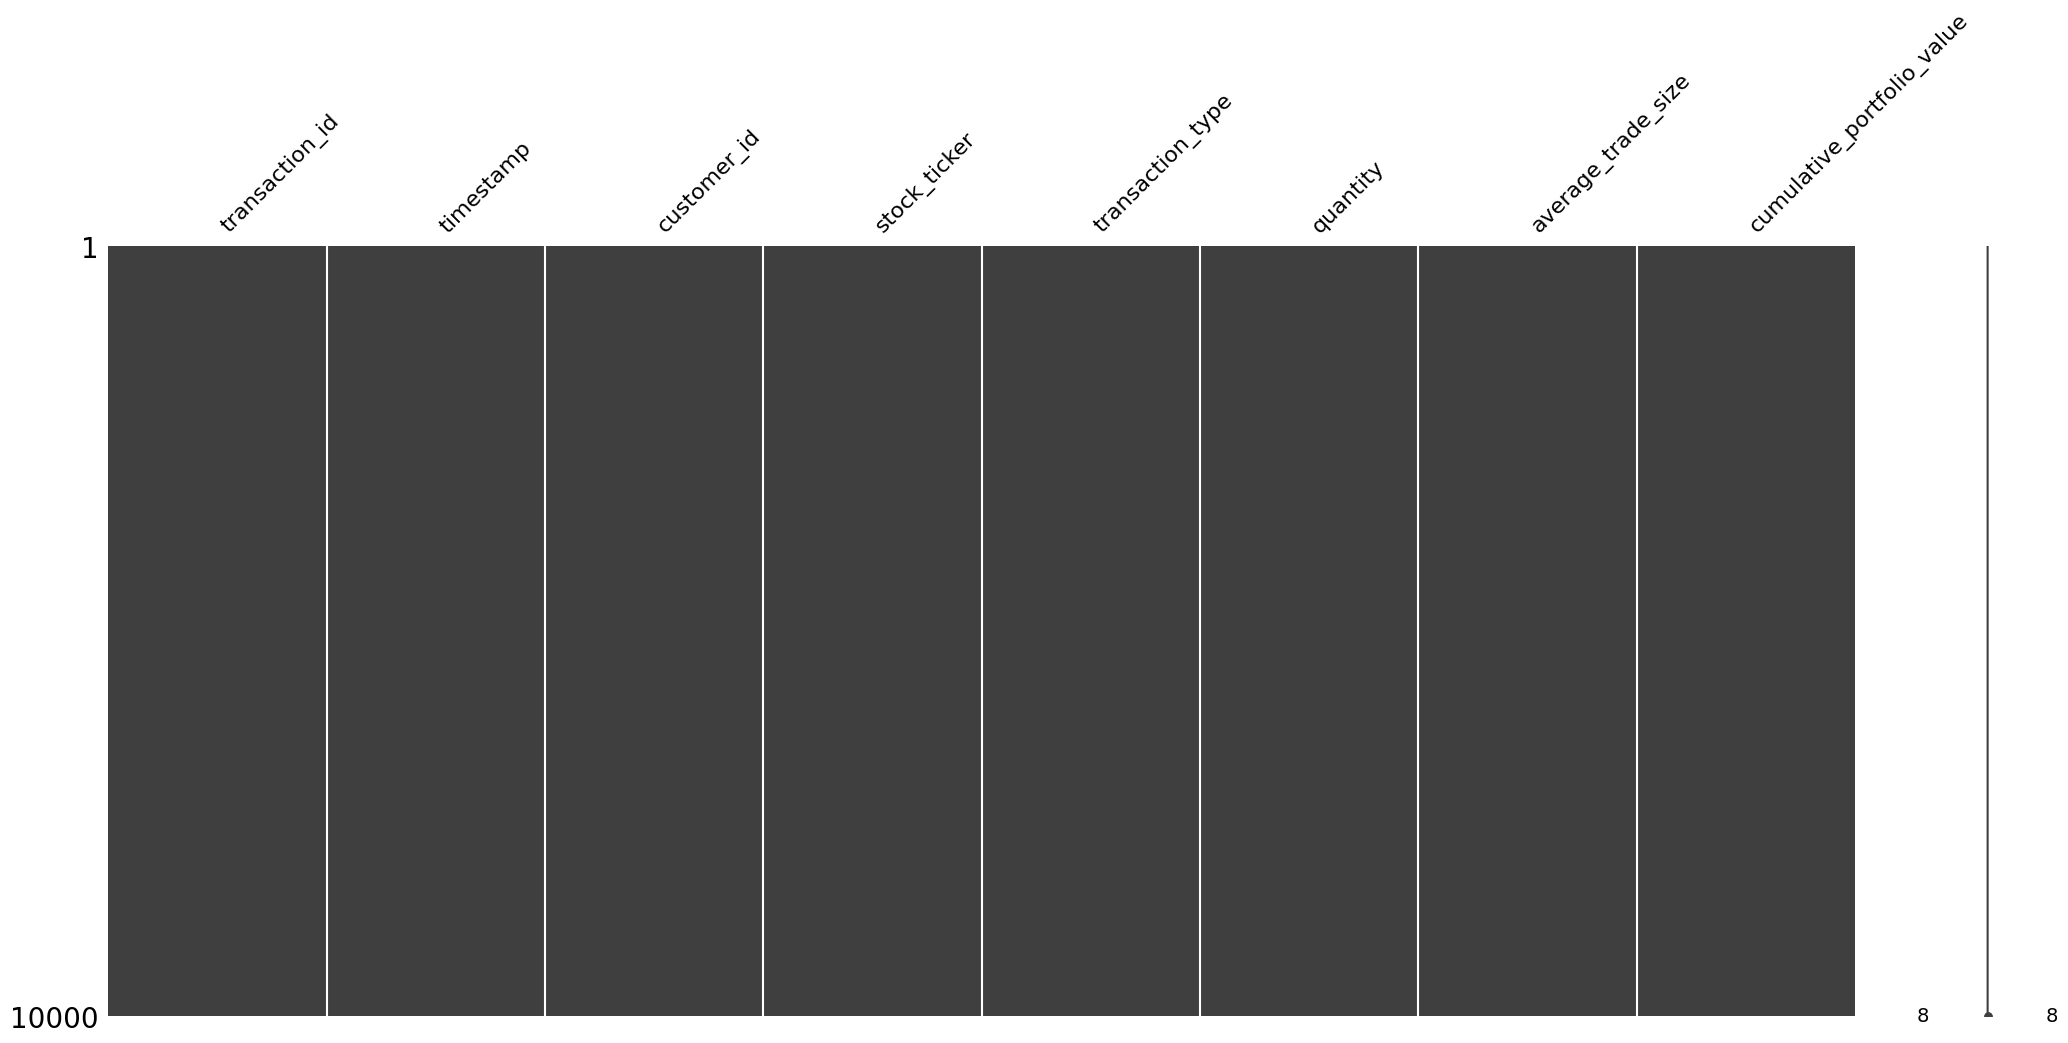

In [219]:
detect_missing_values(trades_df)

# Outliers Detection

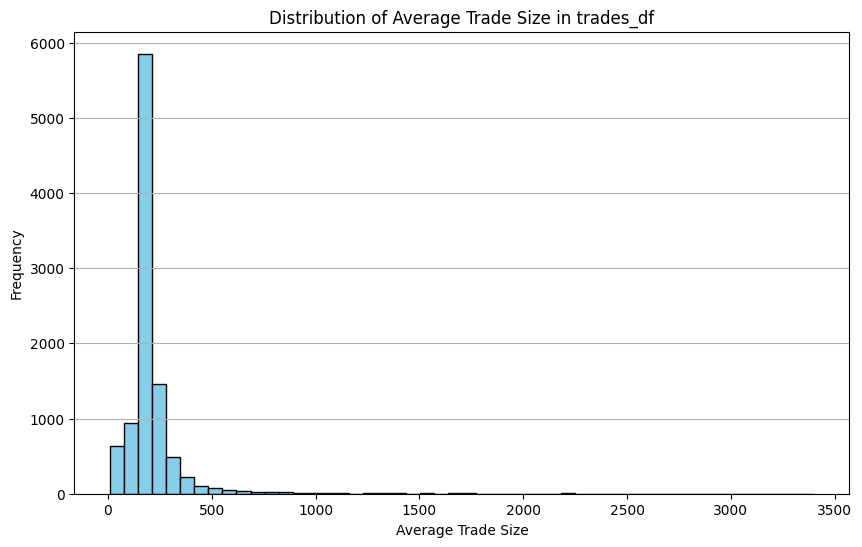

In [220]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(trades_df['average_trade_size'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Average Trade Size')
plt.ylabel('Frequency')
plt.title('Distribution of Average Trade Size in trades_df')
plt.grid(axis='y')
plt.show()


In [223]:
detect_outliers_iqr(trades_df, threshold=0.2) # taking 20% to skip cumulative_portfolio_value as it is not needed in the final dataframe

Column: transaction_id, Outliers: 0
Column: customer_id, Outliers: 0
Column: quantity, Outliers: 765
Column: average_trade_size, Outliers: 2525
Column: cumulative_portfolio_value, Outliers: 1037
Columns with more than 20.0% outliers: ['average_trade_size']


['average_trade_size']

# Handling Outliers

In [244]:
trades_df_cleaned = handle_outliers(trades_df, method='cap', threshold=0.2)


Outlier Handling Report (Threshold: 20.0%)

  transaction_id: 0 outliers (0.00%) - SKIPPED
  customer_id: 0 outliers (0.00%) - SKIPPED
  quantity: 765 outliers (7.65%) - SKIPPED
✓ average_trade_size: 2525 outliers (25.25%) - HANDLING
  cumulative_portfolio_value: 1037 outliers (10.37%) - SKIPPED




In [245]:
detect_outliers_iqr(trades_df_cleaned, threshold=0.2)

Column: transaction_id, Outliers: 0
Column: customer_id, Outliers: 0
Column: quantity, Outliers: 765
Column: average_trade_size, Outliers: 0
Column: cumulative_portfolio_value, Outliers: 1037
Columns with more than 20.0% outliers: []


[]

---------------
## dim_stock

In [246]:
dim_stock_df#.head()

,stock_key,stock_ticker,company_name,liquidity_tier,sector,industry
0,1,STK001,STK001 Corp,Low,Energy,Utilities
1,2,STK002,STK002 Corp,Low,Consumer,Retail
2,3,STK003,STK003 Corp,Low,Technology,Software
3,4,STK004,STK004 Corp,Low,Finance,Asset Management
4,5,STK005,STK005 Corp,Low,Energy,Renewables
5,6,STK006,STK006 Corp,High,Energy,Oil & Gas
6,7,STK007,STK007 Corp,Mid,Energy,Oil & Gas
7,8,STK008,STK008 Corp,High,Energy,Oil & Gas
8,9,STK009,STK009 Corp,High,Technology,Hardware
9,10,STK010,STK010 Corp,High,Consumer,Retail


In [247]:
dim_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   stock_key       20 non-null     int64 
 1   stock_ticker    20 non-null     object
 2   company_name    20 non-null     object
 3   liquidity_tier  20 non-null     object
 4   sector          20 non-null     object
 5   industry        20 non-null     object
dtypes: int64(1), object(5)
memory usage: 1.1+ KB


In [248]:
dim_stock_df.describe()

,stock_key
count,20.00000
mean,10.50000
std,5.91608
min,1.00000
25%,5.75000
50%,10.50000
75%,15.25000
max,20.00000


# Missing Values Detection

stock_key         0
stock_ticker      0
company_name      0
liquidity_tier    0
sector            0
industry          0
dtype: int64

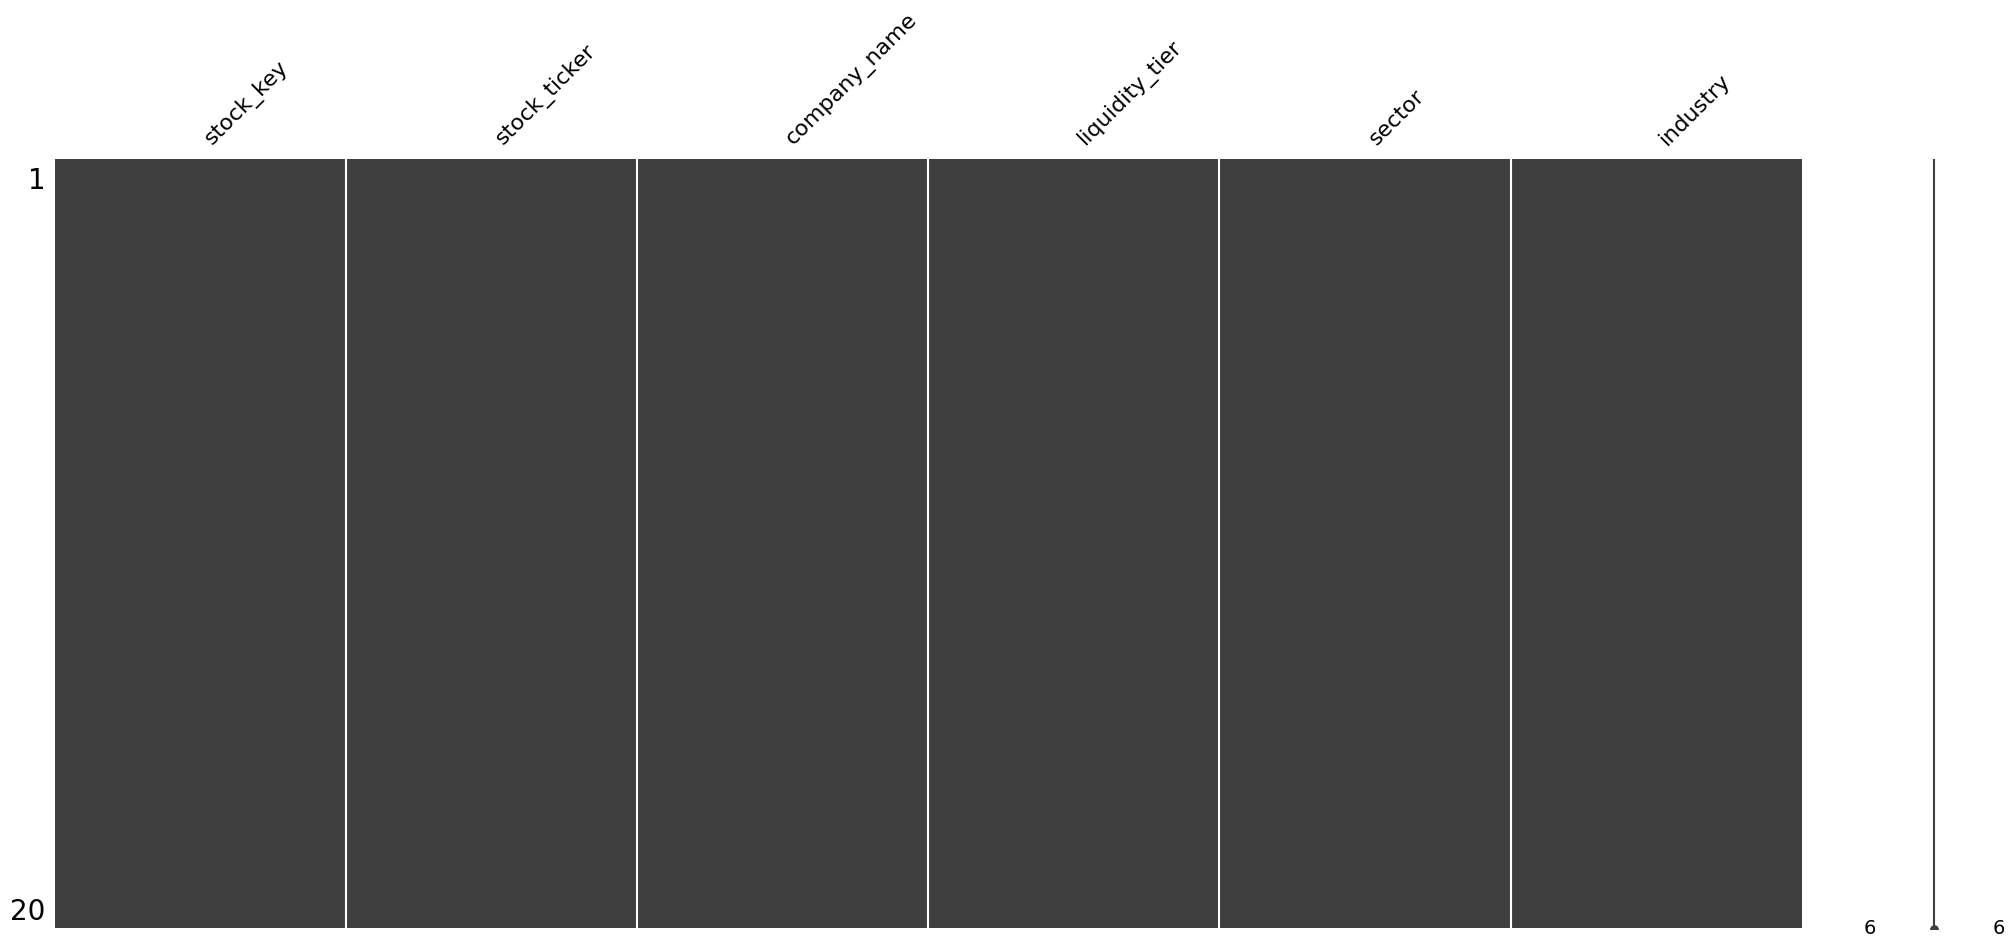

In [249]:
detect_missing_values(dim_stock_df)

# Outliers Detection

In [250]:
detect_outliers_iqr(dim_stock_df)

Column: stock_key, Outliers: 0
Columns with more than 10.0% outliers: []


[]

# Duplicates Detection

In [251]:
detect_duplicate_rows(dim_stock_df)

Number of duplicate rows: 0


--------------------
## dim_date

In [252]:
dim_date_df.head()

,date_key,date,day,month,month_name,quarter,year,day_of_week,day_name,is_weekend,is_holiday
0,20230102,2023-01-02,2,1,January,1,2023,1,Monday,False,False
1,20230103,2023-01-03,3,1,January,1,2023,2,Tuesday,False,False
2,20230104,2023-01-04,4,1,January,1,2023,3,Wednesday,False,False
3,20230105,2023-01-05,5,1,January,1,2023,4,Thursday,False,False
4,20230106,2023-01-06,6,1,January,1,2023,5,Friday,False,False


In [253]:
dim_date_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_key     504 non-null    int64         
 1   date         504 non-null    datetime64[ns]
 2   day          504 non-null    int64         
 3   month        504 non-null    int64         
 4   month_name   504 non-null    object        
 5   quarter      504 non-null    int64         
 6   year         504 non-null    int64         
 7   day_of_week  504 non-null    int64         
 8   day_name     504 non-null    object        
 9   is_weekend   504 non-null    bool          
 10  is_holiday   504 non-null    bool          
dtypes: bool(2), datetime64[ns](1), int64(6), object(2)
memory usage: 36.6+ KB


In [254]:
dim_date_df.describe()

,date_key,date,day,month,quarter,year,day_of_week
count,5.040000e+02,504,504.000000,504.000000,504.000000,504.000000,504.000000
mean,2.023549e+07,2023-12-19 07:14:17.142857216,15.630952,6.305556,2.450397,2023.484127,2.996032
min,2.023010e+07,2023-01-02 00:00:00,1.000000,1.000000,1.000000,2023.000000,1.000000
25%,2.023063e+07,2023-06-26 18:00:00,8.000000,3.000000,1.000000,2023.000000,2.000000
50%,2.023122e+07,2023-12-19 12:00:00,16.000000,6.000000,2.000000,2023.000000,3.000000
75%,2.024061e+07,2024-06-12 06:00:00,23.000000,9.000000,3.000000,2024.000000,4.000000
max,2.024120e+07,2024-12-05 00:00:00,31.000000,12.000000,4.000000,2024.000000,5.000000
std,4.992606e+03,NaN,8.841138,3.348821,1.101923,0.500245,1.414208


# Missing Values Detection

date_key       0
date           0
day            0
month          0
month_name     0
quarter        0
year           0
day_of_week    0
day_name       0
is_weekend     0
is_holiday     0
dtype: int64

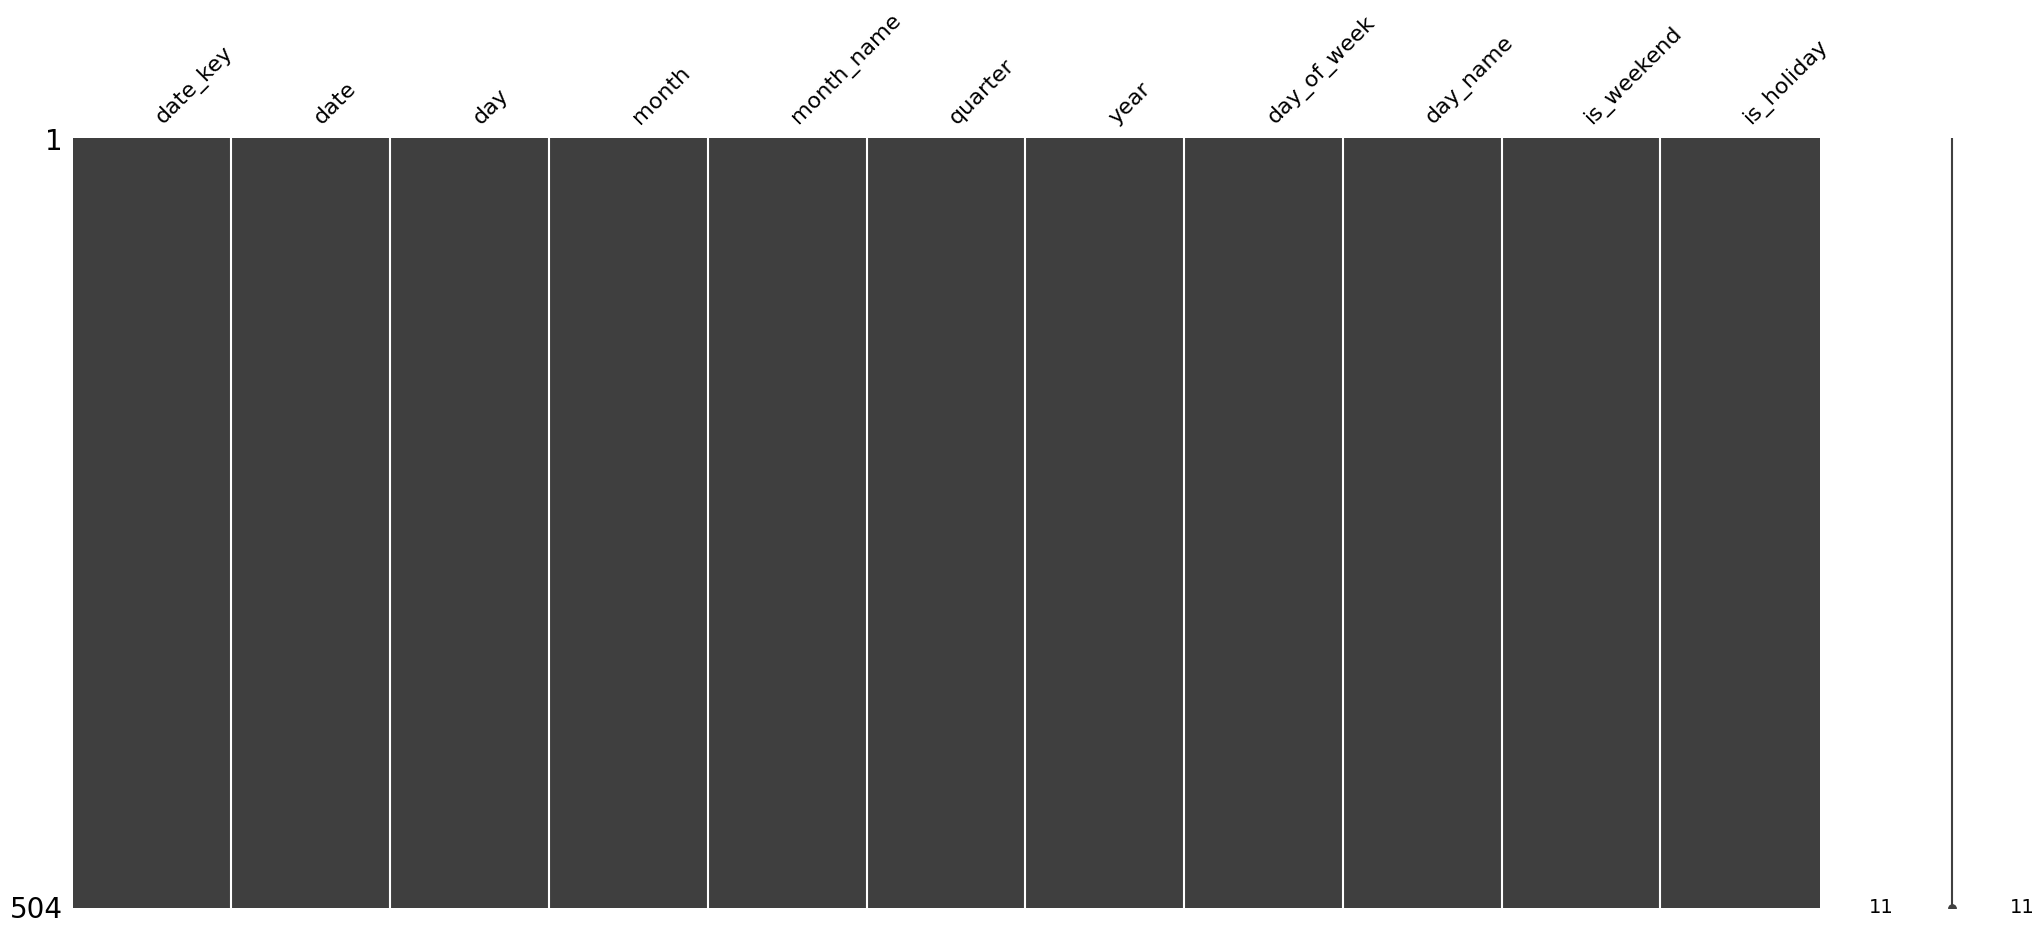

In [255]:
detect_missing_values(dim_date_df)

In [256]:
# change 'date' column to datetime data type
dim_date_df['date'] = pd.to_datetime(dim_date_df['date'])
dim_date_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_key     504 non-null    int64         
 1   date         504 non-null    datetime64[ns]
 2   day          504 non-null    int64         
 3   month        504 non-null    int64         
 4   month_name   504 non-null    object        
 5   quarter      504 non-null    int64         
 6   year         504 non-null    int64         
 7   day_of_week  504 non-null    int64         
 8   day_name     504 non-null    object        
 9   is_weekend   504 non-null    bool          
 10  is_holiday   504 non-null    bool          
dtypes: bool(2), datetime64[ns](1), int64(6), object(2)
memory usage: 36.6+ KB


-----------
## dim_customer

In [257]:
dim_customer_df.head()

,customer_key,customer_id,account_type,avg_trade_size_baseline
0,1,1,Retail,216.919900
1,2,2,Retail,71.936692
2,3,3,Retail,178.906048
3,4,4,Retail,214.291567
4,5,5,Retail,170.590392


In [258]:
dim_customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_key             5000 non-null   int64  
 1   customer_id              5000 non-null   int64  
 2   account_type             5000 non-null   object 
 3   avg_trade_size_baseline  5000 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 156.4+ KB


In [259]:
dim_customer_df.describe()

,customer_key,customer_id,avg_trade_size_baseline
count,5000.000000,5000.000000,5000.000000
mean,2500.500000,2500.500000,130.809940
std,1443.520003,1443.520003,51.875229
min,1.000000,1.000000,40.001518
25%,1250.750000,1250.750000,86.708160
50%,2500.500000,2500.500000,131.415167
75%,3750.250000,3750.250000,176.527320
max,5000.000000,5000.000000,219.989145


# Missing Values Detection

customer_key               0
customer_id                0
account_type               0
avg_trade_size_baseline    0
dtype: int64

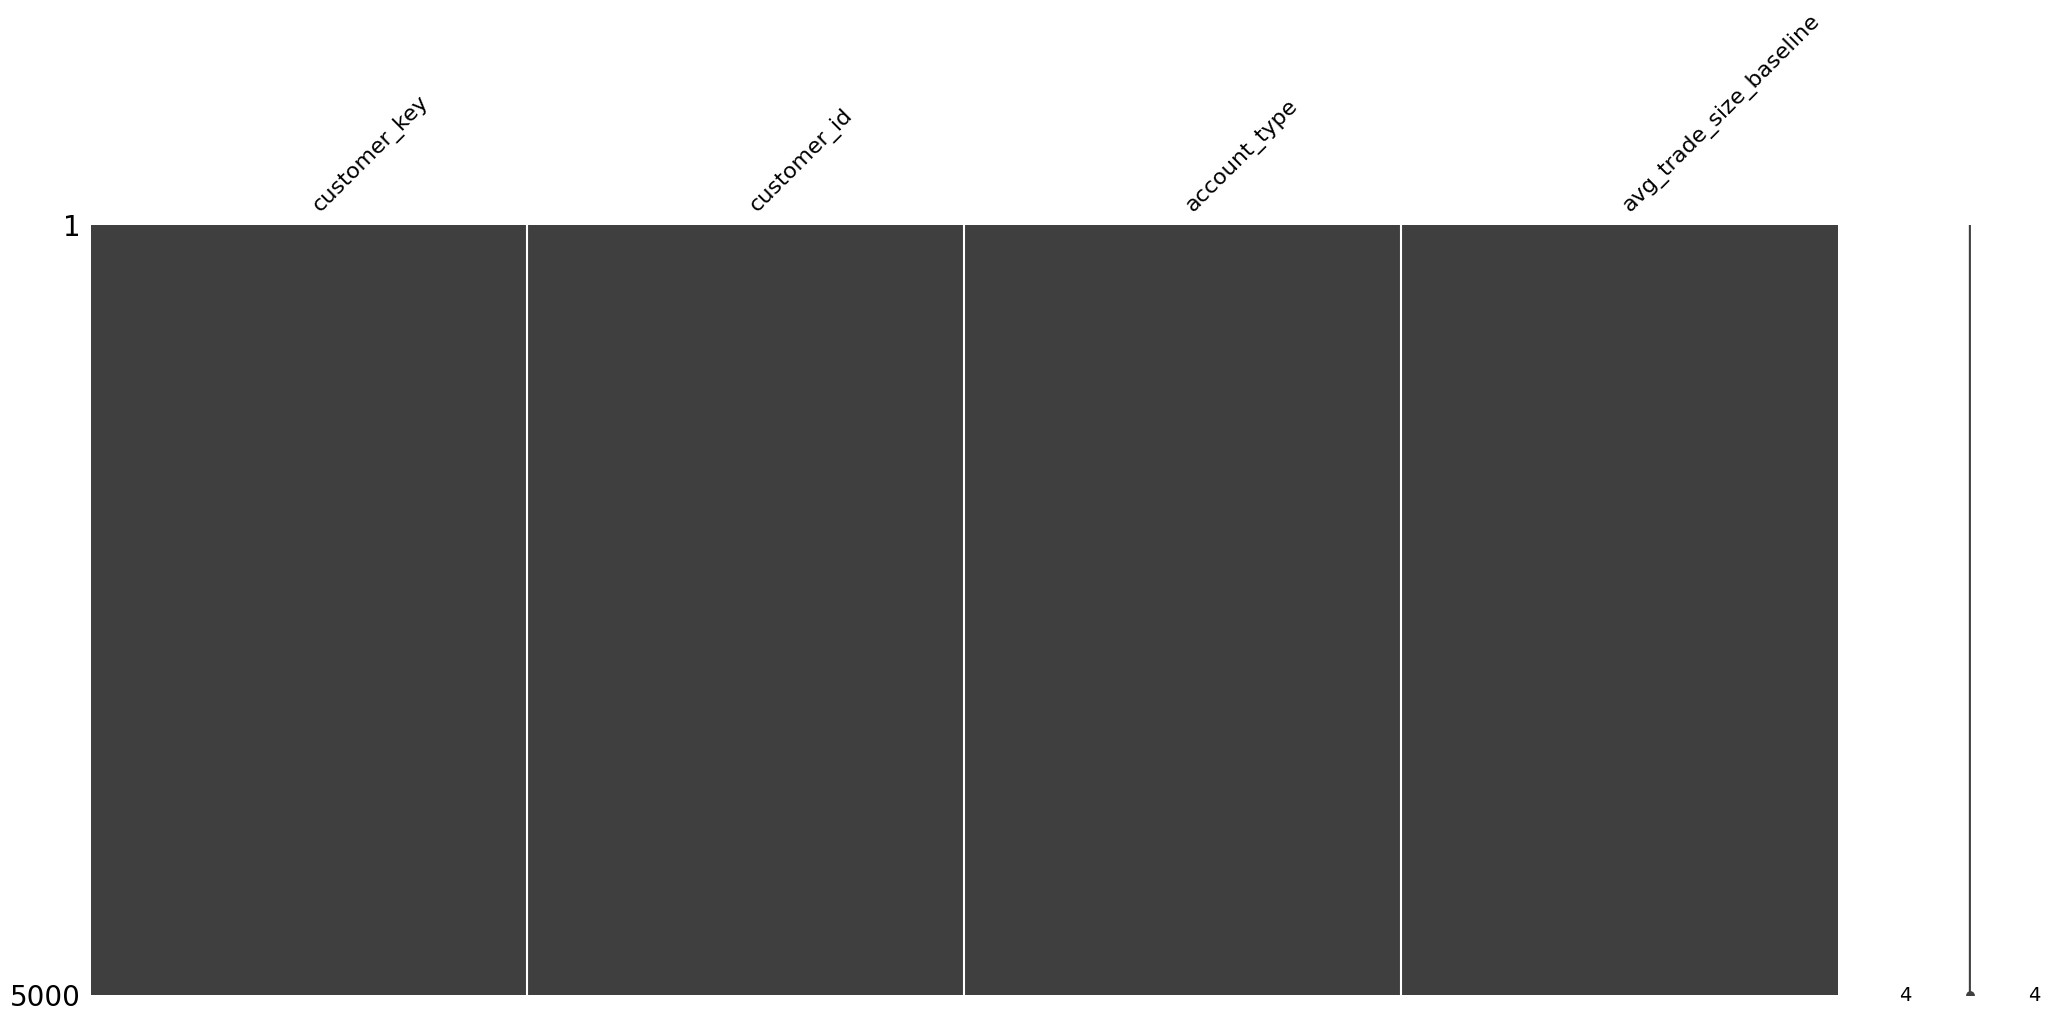

In [260]:
detect_missing_values(dim_customer_df)

# Inconsistency Detection

In [261]:
# check if customer_key and customer_id are always the same
dim_customer_df[dim_customer_df['customer_key'] != dim_customer_df['customer_id']]

,customer_key,customer_id,account_type,avg_trade_size_baseline


In [262]:
detect_duplicate_rows(dim_customer_df)

Number of duplicate rows: 0


# Outliers Detection

In [263]:
detect_outliers_iqr(dim_customer_df)

Column: customer_key, Outliers: 0
Column: customer_id, Outliers: 0
Column: avg_trade_size_baseline, Outliers: 0
Columns with more than 10.0% outliers: []


[]

-----------------
-----------------
# Data Integration
- target = transaction_id, timestamp, customer_id, stock_ticker, transaction_type, quantity, average_trade_size, stock_price, total_trade_amount = (stock_price * quantity), customer_account_type, day_name, is_weekend, is_holiday, stock_liquidity_tier, stock_sector, stock_industry

In [264]:
# test melting cleaned_daily_trade_prices_df
print(cleaned_daily_trade_prices_df.shape)
melted_daily_trade_prices_df = pd.melt(cleaned_daily_trade_prices_df, id_vars=['date'], var_name='stock_ticker', value_name='stock_price')
print(melted_daily_trade_prices_df.shape)

# change 'date' column to datetime data type
melted_daily_trade_prices_df['date'] = pd.to_datetime(melted_daily_trade_prices_df['date'])
melted_daily_trade_prices_df.info()

(504, 21)
(10080, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          10080 non-null  datetime64[ns]
 1   stock_ticker  10080 non-null  object        
 2   stock_price   10080 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 236.4+ KB


In [265]:
# from trades_df get transaction_id	timestamp	customer_id	stock_ticker	transaction_type	quantity	average_trade_size
merged_df = trades_df_cleaned[['transaction_id', 'timestamp', 'customer_id', 'stock_ticker', 'transaction_type', 'quantity', 'average_trade_size']].copy()
merged_df.head()

,transaction_id,timestamp,customer_id,stock_ticker,transaction_type,quantity,average_trade_size
0,1,2023-01-02,4747,STK002,BUY,15,121.72625
1,2,2023-01-02,4747,STK004,BUY,68,121.72625
2,3,2023-01-02,227,STK006,BUY,49,121.72625
3,4,2023-01-02,4747,STK006,BUY,503,195.33000
4,5,2023-01-02,3938,STK006,BUY,203,203.00000


In [268]:
# get stock_price from daily_trade_prices_df based on date and stock_ticker, date is the same as timestamp in trades_df
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])
merged_df = merged_df.merge(melted_daily_trade_prices_df, left_on=['timestamp', 'stock_ticker'], right_on=['date', 'stock_ticker'], how='left')

# calculate total_trade_amount = stock_price * quantity
merged_df['total_trade_amount'] = merged_df['stock_price'] * merged_df['quantity']

# from dim_customer_df get customer_account_type based on customer_id
merged_df = merged_df.merge(dim_customer_df[['customer_id', 'account_type']], on='customer_id', how='left')

# from dim_date_df get day_name, is_weekend, is_holiday based on timestamp
merged_df = merged_df.merge(dim_date_df[['date', 'day_name', 'is_weekend', 'is_holiday']], left_on='timestamp', right_on='date', how='left')

# from dim_stock_df get stock_liquidity_tier, stock_sector, stock_industry based on stock_ticker
merged_df = merged_df.merge(dim_stock_df[['stock_ticker', 'liquidity_tier', 'sector', 'industry']], on='stock_ticker', how='left')

# rename columns to match target
merged_df = merged_df.rename(columns={
    'account_type': 'customer_account_type',
    'liquidity_tier': 'stock_liquidity_tier',
    'sector': 'stock_sector',
    'industry': 'stock_industry'
})

# handle unnecessary date columns, due to joining on date
merged_df = merged_df.drop(columns=['date_x', 'date_y'], errors='ignore')

merged_df.head()


,transaction_id,timestamp,customer_id,stock_ticker,transaction_type,quantity,average_trade_size,stock_price,total_trade_amount,customer_account_type,day_name,is_weekend,is_holiday,stock_liquidity_tier,stock_sector,stock_industry
0,1,2023-01-02,4747,STK002,BUY,15,121.72625,143.732847,2155.992711,Retail,Monday,False,False,Low,Consumer,Retail
1,2,2023-01-02,4747,STK004,BUY,68,121.72625,41.721087,2837.033907,Retail,Monday,False,False,Low,Finance,Asset Management
2,3,2023-01-02,227,STK006,BUY,49,121.72625,136.613229,6694.048200,Retail,Monday,False,False,High,Energy,Oil & Gas
3,4,2023-01-02,4747,STK006,BUY,503,195.33000,136.613229,68716.453976,Retail,Monday,False,False,High,Energy,Oil & Gas
4,5,2023-01-02,3938,STK006,BUY,203,203.00000,136.613229,27732.485402,Retail,Monday,False,False,High,Energy,Oil & Gas


In [269]:
merged_df.info()
merged_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   transaction_id         10000 non-null  int64         
 1   timestamp              10000 non-null  datetime64[ns]
 2   customer_id            10000 non-null  int64         
 3   stock_ticker           10000 non-null  object        
 4   transaction_type       10000 non-null  object        
 5   quantity               10000 non-null  int64         
 6   average_trade_size     10000 non-null  float64       
 7   stock_price            10000 non-null  float64       
 8   total_trade_amount     10000 non-null  float64       
 9   customer_account_type  10000 non-null  object        
 10  day_name               10000 non-null  object        
 11  is_weekend             10000 non-null  bool          
 12  is_holiday             10000 non-null  bool          
 13  st

(10000, 16)